## Logistic Regression
Dropped id and statuses_count, log transformed numerical variables

In [25]:
# remove: CV AUC: 0.8238099273463011
# set caps: CV AUC: 0.8214540494567781
# log transform: CV AUC: 0.8521549006920062
# dropped 'id' and 'statuses_count', managed outliers from numerical variables
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import zscore

def build_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ])
    return model

# Outlier removal before modeling
def remove_outliers(df, numeric_cols):
    num_cols_for_outlier = [col for col in numeric_cols if col not in ['id', 'target']]
    z_scores = np.abs(df[num_cols_for_outlier].apply(zscore))
    outlier_mask = (z_scores > 3).any(axis=1)
    print(f"Total rows with any outlier (z-score > 3): {outlier_mask.sum()}")
    df_no_outliers = df[~outlier_mask].reset_index(drop=True)
    print(f"Shape after outlier removal: {df_no_outliers.shape}")
    return df_no_outliers

def set_caps(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            lower_bound = df[col].quantile(0.05)
            upper_bound = df[col].quantile(0.95)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def log_transform(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            df[col] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    return df

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    X = train.drop(columns=["target", "id", "statuses_count"])
    y = train["target"]

    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns

    # Remove outliers
    train = pd.concat([X, y], axis=1)
    # train = remove_outliers(train, numeric_cols)
    # train = set_caps(train, numeric_cols)
    train = log_transform(train, numeric_cols.drop(["account_age_days"], errors='ignore'))
    X = train.drop(columns=["target"])
    y = train["target"]

    model = build_pipeline(numeric_cols, categorical_cols)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print("CV AUC:", auc_scores.mean())

    # Train full model
    model.fit(X, y)

    # Save model
    # joblib.dump(model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/logistic_regression.pkl")

    # Predict on test
    test_probs = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })
    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)


CV AUC: 0.8517230255621744


Experimented with different handling of outliers: 
- removing them
- set caps
- log transform
- caps + log transform

Best AUC score is from doing log transform on all the numerical variables. 

However, I realised that not all need to be transformed, since account_age_days distribution is not very skewed. Then did log transformation on all numerical columns except for account_age_days. But AUC score fell to 0.8517230255621744. Noticed that this may be because account_age_days has a high correlation with the target variable.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import joblib

# Load data
train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
X = train.drop(columns=["target", "id", "statuses_count"])
y = train["target"]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Log-transform skewed features
for col in numeric_cols:
        if col not in ['id', 'target']:
            X[col] = X[col].apply(lambda x: np.log1p(x) if x > 0 else 0)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Full pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],   # regularization strength
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs"]
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Evaluate on validation set
val_probs = grid.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_probs)
print("Validation AUC:", auc)
print(classification_report(y_val, grid.predict(X_val)))
print("Best hyperparameters:", grid.best_params_)
# best_params = {k.replace("classifier__", ""): v for k, v in grid.best_params_.items()}


# Retrain on full train + validation for final model
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
final_model = grid.best_estimator_
final_model.fit(X_full, y_full)
# final_model = Pipeline([
#     ("preprocessor", preprocessor),
#     ("classifier", LogisticRegression(**best_params))
# ])


# Save final model
joblib.dump(final_model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/logistic_regression_final.pkl")

# Predict on test
test = test.drop(columns=["id", "statuses_count"])
test = log_transform(test, numeric_cols)

test_probs = model.predict_proba(test)[:, 1]
submission = pd.DataFrame({
    "index": test.index,
    "target": test_probs
})
submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)

Validation AUC: 0.8510820828185515
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3485
           1       0.74      0.64      0.69      1757

    accuracy                           0.80      5242
   macro avg       0.78      0.76      0.77      5242
weighted avg       0.80      0.80      0.80      5242

Best hyperparameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Performed GridsearchCV to find best hyperparameter.

Best hyperparameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Validation AUC: 0.8510820828185515

Note: AUC decreased after hyperparameter tuning.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import zscore
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

def build_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42
        ))
    ])
    return model

# Outlier removal before modeling
def remove_outliers(df, numeric_cols):
    num_cols_for_outlier = [col for col in numeric_cols if col not in ['id', 'target']]
    z_scores = np.abs(df[num_cols_for_outlier].apply(zscore))
    outlier_mask = (z_scores > 3).any(axis=1)
    print(f"Total rows with any outlier (z-score > 3): {outlier_mask.sum()}")
    df_no_outliers = df[~outlier_mask].reset_index(drop=True)
    print(f"Shape after outlier removal: {df_no_outliers.shape}")
    return df_no_outliers

def set_caps(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            lower_bound = df[col].quantile(0.05)
            upper_bound = df[col].quantile(0.95)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def log_transform(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            df[col] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    return df

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    X = train.drop(columns=["target", "id", "statuses_count"])
    y = train["target"]

    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns

    # Preprocess training data
    train = pd.concat([X, y], axis=1)
    # train = remove_outliers(train, numeric_cols)
    # train = set_caps(train, numeric_cols)
    train = log_transform(train, numeric_cols)
    X = train.drop(columns=["target"])
    y = train["target"]

    model = build_pipeline(numeric_cols, categorical_cols)

    # Hyperparameter search space for XGBoost
    param_dist = {
        "classifier__n_estimators": randint(100, 600),
        "classifier__max_depth": randint(3, 10),
        "classifier__learning_rate": uniform(0.01, 0.3),
        "classifier__subsample": uniform(0.6, 0.4),
        "classifier__colsample_bytree": uniform(0.6, 0.4)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=30,
        scoring="roc_auc",
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=42
    )

    search.fit(X, y)
    print("Best AUC from CV:", search.best_score_)
    print("Best Params:", search.best_params_)

    # Train final model with best params
    final_model = search.best_estimator_
    final_model.fit(X, y)

    # Save model
    joblib.dump(final_model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_tuned.pkl")

    # Predict on test
    # test = test.drop(columns=["id", "statuses_count"])
    # test = log_transform(test, numeric_cols)

    # test_probs = final_model.predict_proba(test)[:, 1]
    # submission = pd.DataFrame({
    #     "index": test.index,
    #     "target": test_probs
    # })
    # submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:52:56] WARNING: /Users/runner/work/

Best AUC from CV: 0.9371778751271576
Best Params: {'classifier__colsample_bytree': np.float64(0.8170784332632994), 'classifier__learning_rate': np.float64(0.052277267492428794), 'classifier__max_depth': 9, 'classifier__n_estimators': 400, 'classifier__subsample': np.float64(0.6298202574719083)}


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [23:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best AUC from CV: 0.9371778751271576
Best Params: {'classifier__colsample_bytree': np.float64(0.8170784332632994), 'classifier__learning_rate': np.float64(0.052277267492428794), 'classifier__max_depth': 9, 'classifier__n_estimators': 400, 'classifier__subsample': np.float64(0.6298202574719083)}


In [21]:
# log transform CV AUC: 0.9359646121770959
# log + cap CV AUC: 0.9331886814105024
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import zscore
from xgboost import XGBClassifier

def build_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss"
        ))
    ])
    return model

# Outlier removal before modeling
def remove_outliers(df, numeric_cols):
    num_cols_for_outlier = [col for col in numeric_cols if col not in ['id', 'target']]
    z_scores = np.abs(df[num_cols_for_outlier].apply(zscore))
    outlier_mask = (z_scores > 3).any(axis=1)
    print(f"Total rows with any outlier (z-score > 3): {outlier_mask.sum()}")
    df_no_outliers = df[~outlier_mask].reset_index(drop=True)
    print(f"Shape after outlier removal: {df_no_outliers.shape}")
    return df_no_outliers

def set_caps(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            lower_bound = df[col].quantile(0.05)
            upper_bound = df[col].quantile(0.95)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def log_transform(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            df[col] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    return df

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    # X = train.drop(columns=["target", "id", "statuses_count"])
    X = train.drop(columns=["target", "id", "statuses_count", "profile_background_image_url", "profile_image_url"])
    y = train["target"]

    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    log_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day', 'account_age_days']
    # numeric_cols=log_cols

    # Preprocess training data
    train = pd.concat([X, y], axis=1)
    # train = remove_outliers(train, numeric_cols)
    # train = set_caps(train, numeric_cols)
    train = log_transform(train, log_cols)
    X = train.drop(columns=["target"])
    y = train["target"]

    model = build_pipeline(numeric_cols, categorical_cols)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print("CV AUC:", auc_scores.mean())

    # Train full model
    model.fit(X, y)

    # Save model
    joblib.dump(model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost.pkl")
    print("Model saved")
    # Predict on test
    test = test.drop(columns=["id", "statuses_count", "profile_background_image_url", "profile_image_url"])
    test = log_transform(test, numeric_cols)

    # test_probs = model.predict_proba(test)[:, 1]
    # submission = pd.DataFrame({
    #     "index": test.index,
    #     "target": test_probs
    # })
    # submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    # print("Submission file created.")

/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/

CV AUC: 0.9412623044669735


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved


KeyError: 'followers_friends_ratio'

Dropping "created_at", "profile_background_image_url", "profile_image_url", "screen_name" in addition to id and statuses count caused the AUC score to fall... for both log only and log + cap

keeping screen name increased the AUC score slightly, but not better than only id + sc (very close)
keep screen_name + created_at increased AUC score to CV AUC: 0.9360743130592096 (slight increase)
Conclusion: drop only id, statuses_count, profile_background_image_url & profile_image_url. And only do log transformation
but the test accuracy fell slightly. But it would make sense.


In [20]:
#Load model
loaded_model = joblib.load("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost.pkl")
test_probs = loaded_model.predict_proba(test)[:, 1]
submission = pd.DataFrame({
    "index": test.index,
    "target": test_probs
})
submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
print("Submission file created.")

Submission file created.


## Introducing feature engineering

In [ ]:
#Introduced feature engineering. 
# NEW COLUMNS: followers_friends_ratio, favourites_per_status, followers_per_day, statuses_per_follower
# cap95 + log transform CV AUC: 0.9400837181192166
# cap99 + log transform CV AUC: 0.9416609251349648
# did not log transform account_age_days because left skewed and not extremely skewed

# log transformed new feautures as well
# cap99 + log transform CV AUC: 0.9417300027451091


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import zscore
from xgboost import XGBClassifier

def build_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss"
        ))
    ])
    return model

# Outlier removal before modeling
def remove_outliers(df, numeric_cols):
    num_cols_for_outlier = [col for col in numeric_cols if col not in ['id', 'target']]
    z_scores = np.abs(df[num_cols_for_outlier].apply(zscore))
    outlier_mask = (z_scores > 3).any(axis=1)
    df_no_outliers = df[~outlier_mask].reset_index(drop=True)
    return df_no_outliers

def set_caps(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            lower_bound = df[col].quantile(0.01)
            upper_bound = df[col].quantile(0.99)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def log_transform(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            df[col] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    return df

def apply_feature_engineering(data, training_caps=None):
    """Apply feature engineering to any dataset"""
    def safe_ratio(num, denom, default=0):
        return np.where(denom == 0, default, num / denom)
    # Create ratio features
    data['followers_friends_ratio'] = safe_ratio(data['followers_count'], data['friends_count'])
    data['favourites_per_status'] = safe_ratio(data['favourites_count'], data['statuses_count'])
    data['followers_per_day'] = safe_ratio(data['followers_count'], data['account_age_days'])
    data['statuses_per_follower'] = safe_ratio(data['statuses_count'], data['followers_count'])
    
    # Apply capping
    if training_caps is None:
        # Calculate caps (for training data)
        caps = {}
        for col in ['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day']:
        # for col in ['followers_friends_ratio']:
            caps[col] = data[col].quantile(0.99)
            data[f'{col}_capped'] = np.minimum(data[col], caps[col])
        data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day'], inplace=True)
        return data, caps
    else:
        # Use provided caps (for test data)
        for col in ['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day']:
        # for col in ['followers_friends_ratio']:
            data[f'{col}_capped'] = np.minimum(data[col], training_caps[col])
        data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day'], inplace=True)
        return data
    
def drop_columns(data):
    return data.drop(columns=["id", "statuses_count", "profile_background_image_url", "profile_image_url"])


if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    train, caps = apply_feature_engineering(train)

    # X = train.drop(columns=["target", "id", "statuses_count"])
    X = drop_columns(train)
    X = X.drop(columns=["target"])
    y = train["target"]

    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    log_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    new_features = ['followers_friends_ratio_capped', 'favourites_per_status_capped', 'followers_per_day_capped', 'statuses_per_follower_capped']
    # log_cols = numeric_cols

    # Preprocess training data
    X = set_caps(X, numeric_cols)
    X = log_transform(X, log_cols + new_features)


    model = build_pipeline(numeric_cols, categorical_cols)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print("CV AUC:", auc_scores.mean())

    # Train full model
    model.fit(X, y)

    # Save model
    joblib.dump(model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost.pkl")
    print("Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    
    test = apply_feature_engineering(test, training_caps=caps)
    test = drop_columns(test)
    test = set_caps(test, numeric_cols)
    test = log_transform(test, log_cols)

    test_probs = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })
    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("Submission file created.")

/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:15:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:15:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:15:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:15:27] WARNING: /Users/runner/work/

CV AUC: 0.9417887579741822


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:15:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved
Submission file created.


Adding these features increased the AUC score of train, but reduced it sharply for test. Signs of overfitting. Now, try to look at the distribution of the created variables to see which ones to log transform. 

change: did not log transfrom account_age days
dropped columns: ["id", "statuses_count", "profile_background_image_url", "profile_image_url"]
log columns: ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
new feature(s): followers_friends_ratio
CV AUC: 0.9363081153615529


In [1]:
#Introduced feature engineering. 
# NEW COLUMNS: followers_friends_ratio, favourites_per_status, followers_per_day, statuses_per_follower
# cap95 + log transform CV AUC: 0.9400837181192166
# cap99 + log transform CV AUC: 0.9416609251349648
# did not log transform account_age_days because left skewed and not extremely skewed

# log transformed new feautures as well
# cap99 + log transform CV AUC: 0.9417300027451091


#did not log transform the new features, merely capped them

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import zscore
from xgboost import XGBClassifier

def build_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss"
        ))
    ])
    return model

# Outlier removal before modeling
def remove_outliers(df, numeric_cols):
    num_cols_for_outlier = [col for col in numeric_cols if col not in ['id', 'target']]
    z_scores = np.abs(df[num_cols_for_outlier].apply(zscore))
    outlier_mask = (z_scores > 3).any(axis=1)
    df_no_outliers = df[~outlier_mask].reset_index(drop=True)
    return df_no_outliers

def set_caps(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            lower_bound = df[col].quantile(0.01)
            upper_bound = df[col].quantile(0.99)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def log_transform(df, numeric_cols):
    for col in numeric_cols:
        if col not in ['id', 'target']:
            df[col] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
    return df

def apply_feature_engineering(data, training_caps=None):
    """Apply feature engineering to any dataset"""
    def safe_ratio(num, denom, mean_val=0):
        return np.where(denom == 0, mean_val, num / denom)
    # Create ratio features
    data['followers_friends_ratio'] = safe_ratio(data['followers_count'], data['friends_count'], mean_val=data['followers_count'].median())
    data['favourites_per_status'] = safe_ratio(data['favourites_count'], data['statuses_count'], mean_val=data['favourites_count'].median())
    data['followers_per_day'] = safe_ratio(data['followers_count'], data['account_age_days'], mean_val=data['followers_count'].median())
    data['statuses_per_follower'] = safe_ratio(data['statuses_count'], data['followers_count'], mean_val=data['statuses_count'].median())

    # Apply capping
    if training_caps is None:
        # Calculate caps (for training data)
        caps = {}
        for col in ['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day']:
        # for col in ['followers_friends_ratio', 'favourites_per_status', 'followers_per_day']:
            caps[col] = data[col].quantile(0.99)
            data[f'{col}_capped'] = np.minimum(data[col], caps[col])
        data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day'], inplace=True)
        # data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'followers_per_day'], inplace=True)
        return data, caps
    else:
        # Use provided caps (for test data)
        for col in ['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day']:
        # for col in ['followers_friends_ratio', 'favourites_per_status', 'followers_per_day']:
            data[f'{col}_capped'] = np.minimum(data[col], training_caps[col])
        data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'statuses_per_follower', 'followers_per_day'], inplace=True)
        # data.drop(columns=['followers_friends_ratio', 'favourites_per_status', 'followers_per_day'], inplace=True)
        return data
    
def drop_columns(data):
    return data.drop(columns=["id", "statuses_count", "profile_background_image_url", "profile_image_url"])


if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    train, caps = apply_feature_engineering(train)

    # X = train.drop(columns=["target", "id", "statuses_count"])
    X = drop_columns(train)
    X = X.drop(columns=["target"])
    y = train["target"]

    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    log_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    new_features = ['followers_friends_ratio_capped', 'favourites_per_status_capped', 'followers_per_day_capped', 'statuses_per_follower_capped']
    # new_features = ['followers_friends_ratio_capped', 'favourites_per_status_capped', 'followers_per_day_capped']
    # log_cols = numeric_cols

    # Preprocess training data
    X = set_caps(X, numeric_cols)
    X = log_transform(X, log_cols + new_features)


    model = build_pipeline(numeric_cols, categorical_cols)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print("CV AUC:", auc_scores.mean())

    # Train full model
    model.fit(X, y)

    # Save model
    joblib.dump(model, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost.pkl")
    print("Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    
    test = apply_feature_engineering(test, training_caps=caps)
    test = drop_columns(test)
    test = set_caps(test, numeric_cols)
    test = log_transform(test, log_cols)

    test_probs = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })
    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("Submission file created.")

/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:27:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:27:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:27:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:27:47] WARNING: /Users/runner/work/

CV AUC: 0.9419004922555446


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved
Submission file created.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X):
    X = X.copy()
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])
    return X

def cap_and_log(X):

    X = X.copy()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        lower, upper = X[col].quantile([0.01, 0.99])
        X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    X_temp = drop_columns(cap_and_log(apply_feature_engineering(X)))

    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    X = train.drop(columns=["target"])

    pipeline = build_pipeline(X)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "id": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")
    print(pipeline.named_steps['model'].feature_importances_)


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:45:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_87570/6201625.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_opti

CV AUC: 0.9416977561208111


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved
✅ Submission created
[0.0112089  0.0404054  0.00825425 ... 0.         0.         0.        ]


In [9]:
importances = pipeline.named_steps["model"].feature_importances_
sorted_features = sorted(zip(importances, pipeline.named_steps["preprocessor"].get_feature_names_out()), reverse=True)
print(sorted_features[-1])



(np.float32(0.0), 'cat__created_at_2006-07-13 09:05:49')


Newly created features: 
Adds:
      - description_has_bot (1/0)
      - description_has_link (1/0)
      - description_len (int)
      - description_word_count (int)

    Adds:
      - friends_per_day
      - friends_per_day_capped
      - friends_per_day_log  (log1p of capped)
      - friends_per_logday_log 

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X):
    X = X.copy()
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        emoji_re = re.compile(
            r"[\U0001F600-\U0001F64F"  # emoticons
            r"\U0001F300-\U0001F5FF"  # symbols & pictographs
            r"\U0001F680-\U0001F6FF"  # transport & map symbols
            r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            r"\U00002702-\U000027B0"  # dingbats
            r"\U000024C2-\U0001F251"  # enclosed characters
            r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            r"\U00002600-\U000026FF"  # miscellaneous symbols
            r"\U00002B00-\U00002BFF"  # arrows
            r"\U0001F700-\U0001F77F"  # alchemical symbols
            r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)
    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0
    return X

def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    X_temp = drop_columns(cap_and_log(apply_feature_engineering(X)))
    # X_temp = drop_columns((apply_feature_engineering(X)))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    X = train.drop(columns=["target"])

    pipeline = build_pipeline(X)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/2164295402.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/2164295402.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/2164295402.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipyke

CV AUC: 0.9433843131061425


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/2164295402.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/2164295402.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)


✅ Submission created


Adding:
- lang binning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X):
    X = X.copy()
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        emoji_re = re.compile(
            r"[\U0001F600-\U0001F64F"  # emoticons
            r"\U0001F300-\U0001F5FF"  # symbols & pictographs
            r"\U0001F680-\U0001F6FF"  # transport & map symbols
            r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            r"\U00002702-\U000027B0"  # dingbats
            r"\U000024C2-\U0001F251"  # enclosed characters
            r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            r"\U00002600-\U000026FF"  # miscellaneous symbols
            r"\U00002B00-\U00002BFF"  # arrows
            r"\U0001F700-\U0001F77F"  # alchemical symbols
            r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)
    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'
    return X

def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "description", "lang"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    X_temp = drop_columns(cap_and_log(apply_feature_engineering(X)))
    # X_temp = drop_columns((apply_feature_engineering(X)))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    X = train.drop(columns=["target"])

    pipeline = build_pipeline(X)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/203976043.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/203976043.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/203976043.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykerne

CV AUC: 0.9428855810390747


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:33:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/203976043.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_89717/203976043.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)


✅ Submission created


current: CV AUC: 0.9431187327116781
best for introducing lang. but still worse than without lang
but accuracy improve: Public score: 0.93732

normal - CV AUC: 0.9431187327116781
friends_per_day -- CV AUC: 0.9428855810390747
friends_per_day (use log inside cap and log) -- CV AUC: 0.9428855810390747
friends_per_day_log - CV AUC: 0.9428855810390747
friends_per_logday -- CV AUC: 0.9428048430903615
friends_per_logday_log - CV AUC: 0.9428045163578505

tried adding friends_per_day -- public score slightly fell to 0.93729


add
- location binning

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None):
    X = X.copy()
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        emoji_re = re.compile(
            r"[\U0001F600-\U0001F64F"  # emoticons
            r"\U0001F300-\U0001F5FF"  # symbols & pictographs
            r"\U0001F680-\U0001F6FF"  # transport & map symbols
            r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            r"\U00002702-\U000027B0"  # dingbats
            r"\U000024C2-\U0001F251"  # enclosed characters
            r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            r"\U00002600-\U000026FF"  # miscellaneous symbols
            r"\U00002B00-\U00002BFF"  # arrows
            r"\U0001F700-\U0001F77F"  # alchemical symbols
            r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)
        # X['description_has_follow'] = desc.str.contains(r'follow|subscribe').fillna(False).astype(int)
        # follow or subscribe
        X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
        # screen name has bot
        # X['screen_name_has_bot'] = X['screen_name'].fillna('').astype(str).str.lower().str.contains(r'bot').fillna(False).astype(int)
    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        X['description_has_follow'] = 0
        # X['screen_name_has_bot'] = 0

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "description", "lang", "location"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # X_temp = drop_columns(cap_and_log(apply_feature_engineering(X)))
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    model = XGBClassifier(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=9,
        subsample=0.98,
        colsample_bytree=0.56,
        reg_alpha=1.23,
        reg_lambda=1.63,
        min_child_weight=3,
        gamma=0.36,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/py

CV AUC: 0.9449133027189713


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2640484755.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)


✅ Submission created


loc binning
CV AUC: 0.9432505489033669
Public score: 0.93680
public score fell   

forgot to drop loc:
after dropping
CV AUC: 0.9433049129833012
improvement from having lang
Public score: 0.93734
improved by 0.00002 aahhahha

added is_geo_and_verified:
CV AUC: 0.9449488278469541
big improvement

added description_has_follow and screen_name_has_bot
CV AUC: 0.9446544454398239
worsen
screen_name_has_bot: CV AUC: 0.9448842968067707
description_has_follow: CV AUC: 0.9449133027189713



In [12]:
# Optuna hyperparameter search for XGBoost pipeline
import optuna
import json
import os
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Paths (adjust if needed)
TRAIN_CSV = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv"
STUDY_DB = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/optuna_study.sqlite"
BEST_PARAMS_PATH = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/best_xgb_params.json"

# load data
train = pd.read_csv(TRAIN_CSV)
y = train["target"]
X_raw = train.drop(columns=["target"])

# build feature-engineered X once for column discovery inside build_pipeline
X_fe, loc_groups = apply_feature_engineering(train)
X = X_fe.drop(columns=["target"])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # sample hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0)
    }

    # build pipeline and set params
    pipeline = build_pipeline(X)
    # set parameters on final estimator via pipeline param naming
    estimator_params = {f"model__{k}": v for k, v in params.items()}
    pipeline.set_params(**estimator_params)

    # evaluate with CV (roc_auc)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=1, error_score='raise')
    return scores.mean()

# create study with SQLite storage to persist results
study = optuna.create_study(direction="maximize", study_name="xgb_pipeline_search",
                            storage=f"sqlite:///{STUDY_DB}", load_if_exists=True)

# run optimization (adjust n_trials)
n_trials = 50
study.optimize(objective, n_trials=n_trials, n_jobs=1)

print("Best trial:")
print(study.best_trial.params)

# save best params
os.makedirs(os.path.dirname(BEST_PARAMS_PATH), exist_ok=True)
with open(BEST_PARAMS_PATH, "w") as f:
    json.dump(study.best_trial.params, f, indent=2)

# mark next todo as in-progress: retrain final model
# (You can now rebuild pipeline with best params and fit on full training set)

/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_54056/162156847.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_54056/162156847.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
[I 2025-10-09 18:09:15,998] Using an existing study with name 'xgb_pipeline_search' instead of creating a new one.
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_54056/2597556985.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

Best trial:
{'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}


In [ ]:
numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-10-09 14:44:11,501] A new study created in memory with name: no-name-8662639e-f689-4ad8-92b7-2639d39848ff
  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-10-09 14:44:11,506] Trial 0 failed with parameters: {'n_estimators': 463, 'learning_rate': 0.040350995490053825, 'max_depth': 6, 'subsample': 0.7433924692499391, 'colsample_bytree': 0.824566975559955, 'gamma': 1.7301559942880935, 'min_child_weight': 8.105361065739086, 'reg_alpha': 0.6225770812922393, 'reg_lambda': 0.2158959080773848} because of the following error: NameError("name 'preprocessor' is not defined").
Traceback (most recent call last):
  File "/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_54056/4214883388.py", line 27, in objective
    ("preprocessor", preprocessor),  # can reuse your built preprocessor
                     ^^^^^^^^^^^^
NameError: name 'preprocessor' is not defined
[W 2025-10-09 14:44:11,510] Trial 0 failed with value None.


NameError: name 'preprocessor' is not defined

trying: defaultprofile and default profile image
with: CV AUC: 0.9428677592571271
without: CV AUC: 0.9431187327116781


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X):
    X = X.copy()
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    # X['default_profile_and_image'] = ((X['default_profile'] == True) & (X['default_profile_image'] == True)).astype(int)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        emoji_re = re.compile(
            r"[\U0001F600-\U0001F64F"  # emoticons
            r"\U0001F300-\U0001F5FF"  # symbols & pictographs
            r"\U0001F680-\U0001F6FF"  # transport & map symbols
            r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            r"\U00002702-\U000027B0"  # dingbats
            r"\U000024C2-\U0001F251"  # enclosed characters
            r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            r"\U00002600-\U000026FF"  # miscellaneous symbols
            r"\U00002B00-\U00002BFF"  # arrows
            r"\U0001F700-\U0001F77F"  # alchemical symbols
            r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)
    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'
    return X

def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "description", "lang"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    X_temp = drop_columns(cap_and_log(apply_feature_engineering(X)))
    # X_temp = drop_columns((apply_feature_engineering(X)))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    X = train.drop(columns=["target"])

    pipeline = build_pipeline(X)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2213273080.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2213273080.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2213273080.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipyke

CV AUC: 0.9431187327116781


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved
✅ Submission created


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2213273080.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_72087/2213273080.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)


original: CV AUC: 0.9462335346853962

trying:
is_geo_or_verified
CV AUC: 0.9460186397060564

is_geo_and_not_verified + is_not_geo_and_verified
CV AUC: 0.9463343384946825 (improvement)

is_geo_and_not_verified CV AUC: 0.9461242200335518
is_not_geo_and_verified CV AUC: 0.9461867435581424

is_geo_and_not_verified + is_not_geo_and_verified + is_geo_or_verified
CV AUC: 0.946380302633559







In [ ]:
#without geoenabled and verified interaction
# CV AUC: 0.9461810576257423
# with 
# CV AUC: 0.9462335346853962
# public score: 0.94147

# add description_has_follow -- CV AUC: 0.9460825004785388 (worsen)

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    # X can be a 1D array or 2D array with shape (n_samples, 1)
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    # reference_date: use a fixed date for reproducibility if provided, otherwise use current date
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)


    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        emoji_re = re.compile(
            r"[\U0001F600-\U0001F64F"  # emoticons
            r"\U0001F300-\U0001F5FF"  # symbols & pictographs
            r"\U0001F680-\U0001F6FF"  # transport & map symbols
            r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            r"\U00002702-\U000027B0"  # dingbats
            r"\U000024C2-\U0001F251"  # enclosed characters
            r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            r"\U00002600-\U000026FF"  # miscellaneous symbols
            r"\U00002B00-\U00002BFF"  # arrows
            r"\U0001F700-\U0001F77F"  # alchemical symbols
            r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)

        # X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)

    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        # X['description_has_follow'] = 0

    # === created_at -> account_age_days ===
    if 'account_age_days' not in X.columns or X['account_age_days'].isna().any():
        if 'created_at' in X.columns:
            # try parsing created_at to days difference from reference_date
            try:
                created = pd.to_datetime(X['created_at'], errors='coerce')
                X['account_age_days'] = (reference_date - created).dt.days.fillna(0).astype(int)
            except Exception:
                # fallback if parsing fails
                X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))
        else:
            # if neither exists, fill with median later through imputer
            X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))

    # === screen_name features ===
    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d').astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_').astype(int)
        # ratio of digits to length
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    # === boolean-like flags to numeric ===
    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    # keep `description` and `screen_name` for text features; drop raw location/lang/ids that we've summarized
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # note: X is expected to already contain feature-engineered cols (main applies apply_feature_engineering)
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
        # ("encoder", OneHotEncoder(max_categories=50, handle_unknown='infrequent_if_exist'))
    ])
    # Add text pipelines if description / screen_name exist
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # description -> TF-IDF -> SVD
    if 'description' in X_temp.columns:
        desc_components = 40
        # ensure we pass a 1D array of strings (no NaN) into TfidfVectorizer
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))

    # screen_name -> TF-IDF -> SVD (shorter)
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    model = XGBClassifier(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=9,
        subsample=0.98,
        colsample_bytree=0.56,
        reg_alpha=1.23,
        reg_lambda=1.63,
        min_child_weight=3,
        gamma=0.36,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Feature importance
    # if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    #     importances = pipeline.named_steps['model'].feature_importances_
    #     print("Feature importances:", importances)

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


CV AUC: 0.946666124621012
✅ Model saved
✅ Model saved
✅ Submission created
✅ Submission created


✅ Model loaded

TOP 50 MOST IMPORTANT FEATURES



,feature,importance
0,desc_text__component_14,0.137697
1,desc_text__component_4,0.092504
2,desc_text__component_1,0.064428
3,desc_text__component_9,0.040198
4,desc_text__component_13,0.033791
5,desc_text__component_16,0.033590
6,desc_text__component_12,0.030007
7,desc_text__component_15,0.029964
8,desc_text__component_3,0.029799
9,desc_text__component_8,0.024362



✅ Feature importances saved to ../outputs/feature_importances.csv


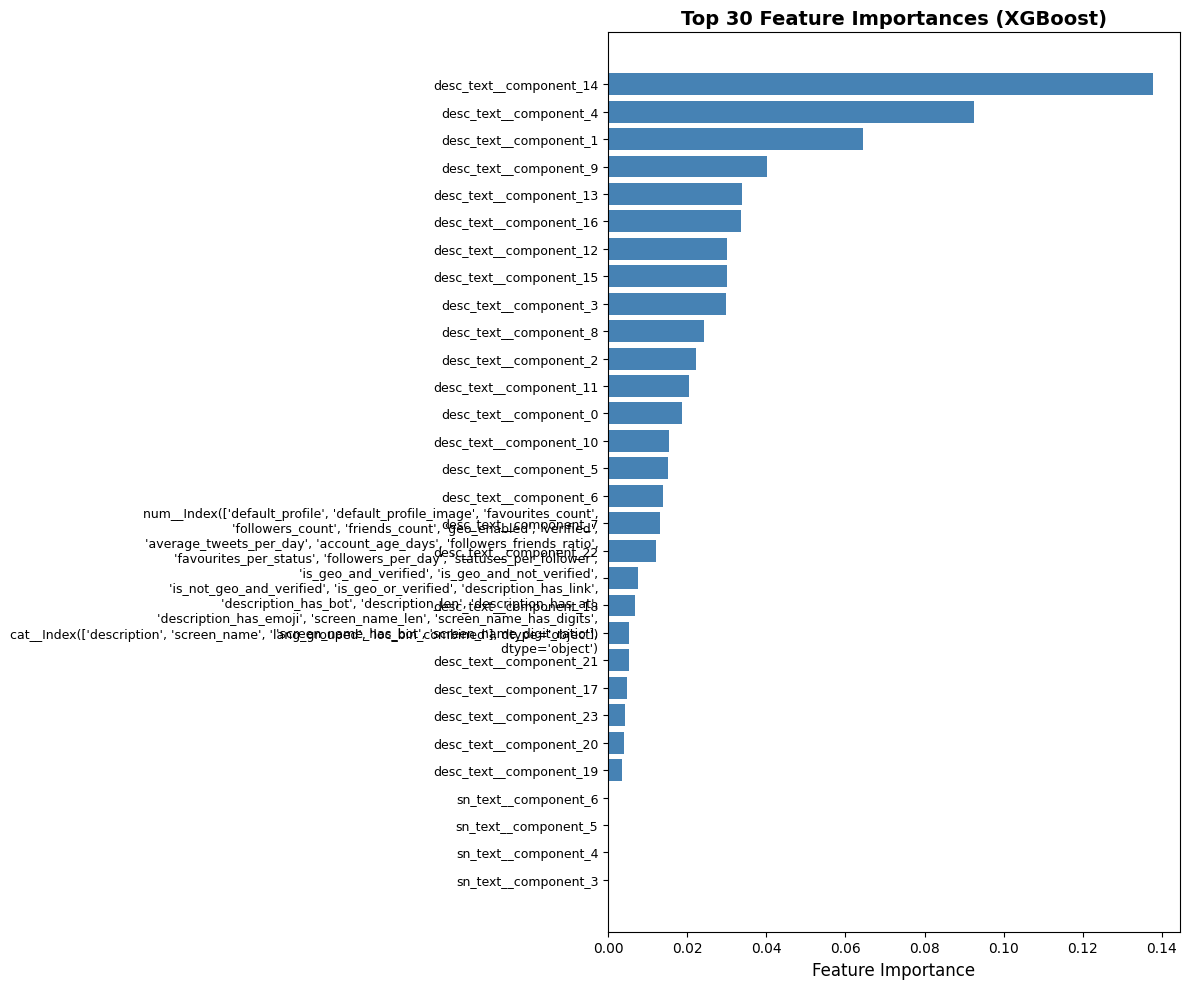


✅ Feature importance plot saved to ../outputs/feature_importance_plot.png

FEATURE IMPORTANCE SUMMARY
Total features: 50
Top 10 features account for: 51.63% of total importance
Top 50 features account for: 68.88% of total importance
Mean importance: 0.013777
Median importance: 0.003725


In [10]:
# ========= Feature Importance Analysis ========= #
import matplotlib.pyplot as plt
import joblib

pipeline = joblib.load("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
print("✅ Model loaded")
# Extract the fitted model and preprocessor from the pipeline
model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessor']

# Get feature importances from XGBoost
importances = model.feature_importances_

# Build feature names from the ColumnTransformer
def get_feature_names_from_column_transformer(ct):
    """Extract feature names from a fitted ColumnTransformer."""
    feature_names = []
    
    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop' or name == 'remainder':
            continue
            
        # Get the column names
        if isinstance(cols, (list, tuple, np.ndarray)):
            input_cols = list(cols)
        else:
            input_cols = [cols]
        
        # Check if transformer is a Pipeline
        if hasattr(transformer, 'named_steps'):
            # Get the last step of the pipeline
            steps = list(transformer.named_steps.values())
            last_step = steps[-1] if steps else transformer
        else:
            last_step = transformer
        
        # Get feature names based on transformer type
        if hasattr(last_step, 'get_feature_names_out'):
            try:
                out_names = last_step.get_feature_names_out(input_cols)
                feature_names.extend([f"{name}__{n}" for n in out_names])
            except:
                # Fallback if get_feature_names_out fails
                if hasattr(last_step, 'n_components'):
                    # For dimensionality reduction (SVD, PCA, etc.)
                    n_comp = last_step.n_components
                    feature_names.extend([f"{name}__component_{i}" for i in range(n_comp)])
                else:
                    feature_names.extend([f"{name}__{c}" for c in input_cols])
        elif isinstance(last_step, TruncatedSVD):
            # Handle TruncatedSVD specifically
            n_comp = last_step.n_components
            feature_names.extend([f"{name}__svd_{i}" for i in range(n_comp)])
        else:
            # Default: use input column names
            feature_names.extend([f"{name}__{c}" for c in input_cols])
    
    return feature_names

try:
    feature_names = get_feature_names_from_column_transformer(preprocessor)
except Exception as e:
    print(f"Error extracting feature names: {e}")
    feature_names = [f"feature_{i}" for i in range(len(importances))]

# Ensure lengths match
if len(feature_names) != len(importances):
    print(f"Warning: {len(feature_names)} feature names but {len(importances)} importances")
    min_len = min(len(feature_names), len(importances))
    feature_names = feature_names[:min_len]
    importances = importances[:min_len]

# Create DataFrame with feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Display top 50 features
print("\n" + "="*80)
print("TOP 50 MOST IMPORTANT FEATURES")
print("="*80 + "\n")
display(feature_importance_df.head(50))

# Save to CSV
output_path = "../outputs/feature_importances.csv"
feature_importance_df.to_csv(output_path, index=False)
print(f"\n✅ Feature importances saved to {output_path}")

# Plot top 30 features
plt.figure(figsize=(12, 10))
top_n = 30
top_features = feature_importance_df.head(top_n)
plt.barh(range(top_n), top_features['importance'], color='steelblue')
plt.yticks(range(top_n), top_features['feature'], fontsize=9)
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/feature_importance_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Feature importance plot saved to ../outputs/feature_importance_plot.png")

# Summary statistics
print("\n" + "="*80)
print("FEATURE IMPORTANCE SUMMARY")
print("="*80)
print(f"Total features: {len(feature_importance_df)}")
print(f"Top 10 features account for: {feature_importance_df.head(10)['importance'].sum():.2%} of total importance")
print(f"Top 50 features account for: {feature_importance_df.head(50)['importance'].sum():.2%} of total importance")
print(f"Mean importance: {feature_importance_df['importance'].mean():.6f}")
print(f"Median importance: {feature_importance_df['importance'].median():.6f}")

⚠️  Total importances available: 50
⚠️  Total features expected: 50 (mismatch detected earlier)

FEATURE SPACE BREAKDOWN (ACTUAL)
Numeric features:          26 features  (indices 0-25)
Other features:            24 features  (indices 26-49)
Total in importance:       50 features

IMPORTANCE CONTRIBUTION BY FEATURE TYPE
Numeric features:      100.00%  (mean: 0.026494)
Other features:          0.00%  (mean: 0.000000)

ALL FEATURES RANKED BY IMPORTANCE



,feature,importance,type,rank
0,is_geo_or_verified,0.137697,numeric,1
1,verified,0.092504,numeric,2
2,followers_count,0.064428,numeric,3
3,followers_per_day,0.040198,numeric,4
4,is_not_geo_and_verified,0.033791,numeric,5
5,description_has_bot,0.033590,numeric,6
6,is_geo_and_not_verified,0.030007,numeric,7
7,description_has_link,0.029964,numeric,8
8,geo_enabled,0.029799,numeric,9
9,favourites_per_status,0.024362,numeric,10



NUMERICAL FEATURES: DETAILED ANALYSIS

All 26 numeric features with cumulative importance:



,rank,feature,importance,% of total,cumulative %
0,1,is_geo_or_verified,0.137697,19.99,19.990000
1,2,verified,0.092504,13.43,33.419998
2,3,followers_count,0.064428,9.35,42.770000
3,4,followers_per_day,0.040198,5.84,48.610001
4,5,is_not_geo_and_verified,0.033791,4.91,53.520000
5,6,description_has_bot,0.033590,4.88,58.400002
6,7,is_geo_and_not_verified,0.030007,4.36,62.759998
7,8,description_has_link,0.029964,4.35,67.110001
8,9,geo_enabled,0.029799,4.33,71.440002
9,10,favourites_per_status,0.024362,3.54,74.980003



FEATURE DROP RECOMMENDATIONS

📊 Low-importance numeric features (< 0.005):
\n   These 4 features have very low importance:
   23. description_len                 (importance: 0.004673, 0.68%)
   24. screen_name_digit_ratio         (importance: 0.004299, 0.62%)
   25. screen_name_len                 (importance: 0.003998, 0.58%)
   26. description_has_emoji           (importance: 0.003452, 0.50%)
\n   💡 Safe to drop?
      • description_has_emoji - Very low impact
      • screen_name_len - Very low impact
      • screen_name_digit_ratio - Very low impact
      • description_len - Keep (might interact with other features)
\n   ⚠️  But consider:
      • They cost almost nothing computationally
      • They may help with model interpretability
      • Test dropping them and see if CV score changes
\n📊 Top performing numeric features (top 5):
    1. is_geo_or_verified              (importance: 0.137697, 19.99%)
    2. verified                        (importance: 0.092504, 13.43%)
    3. fo

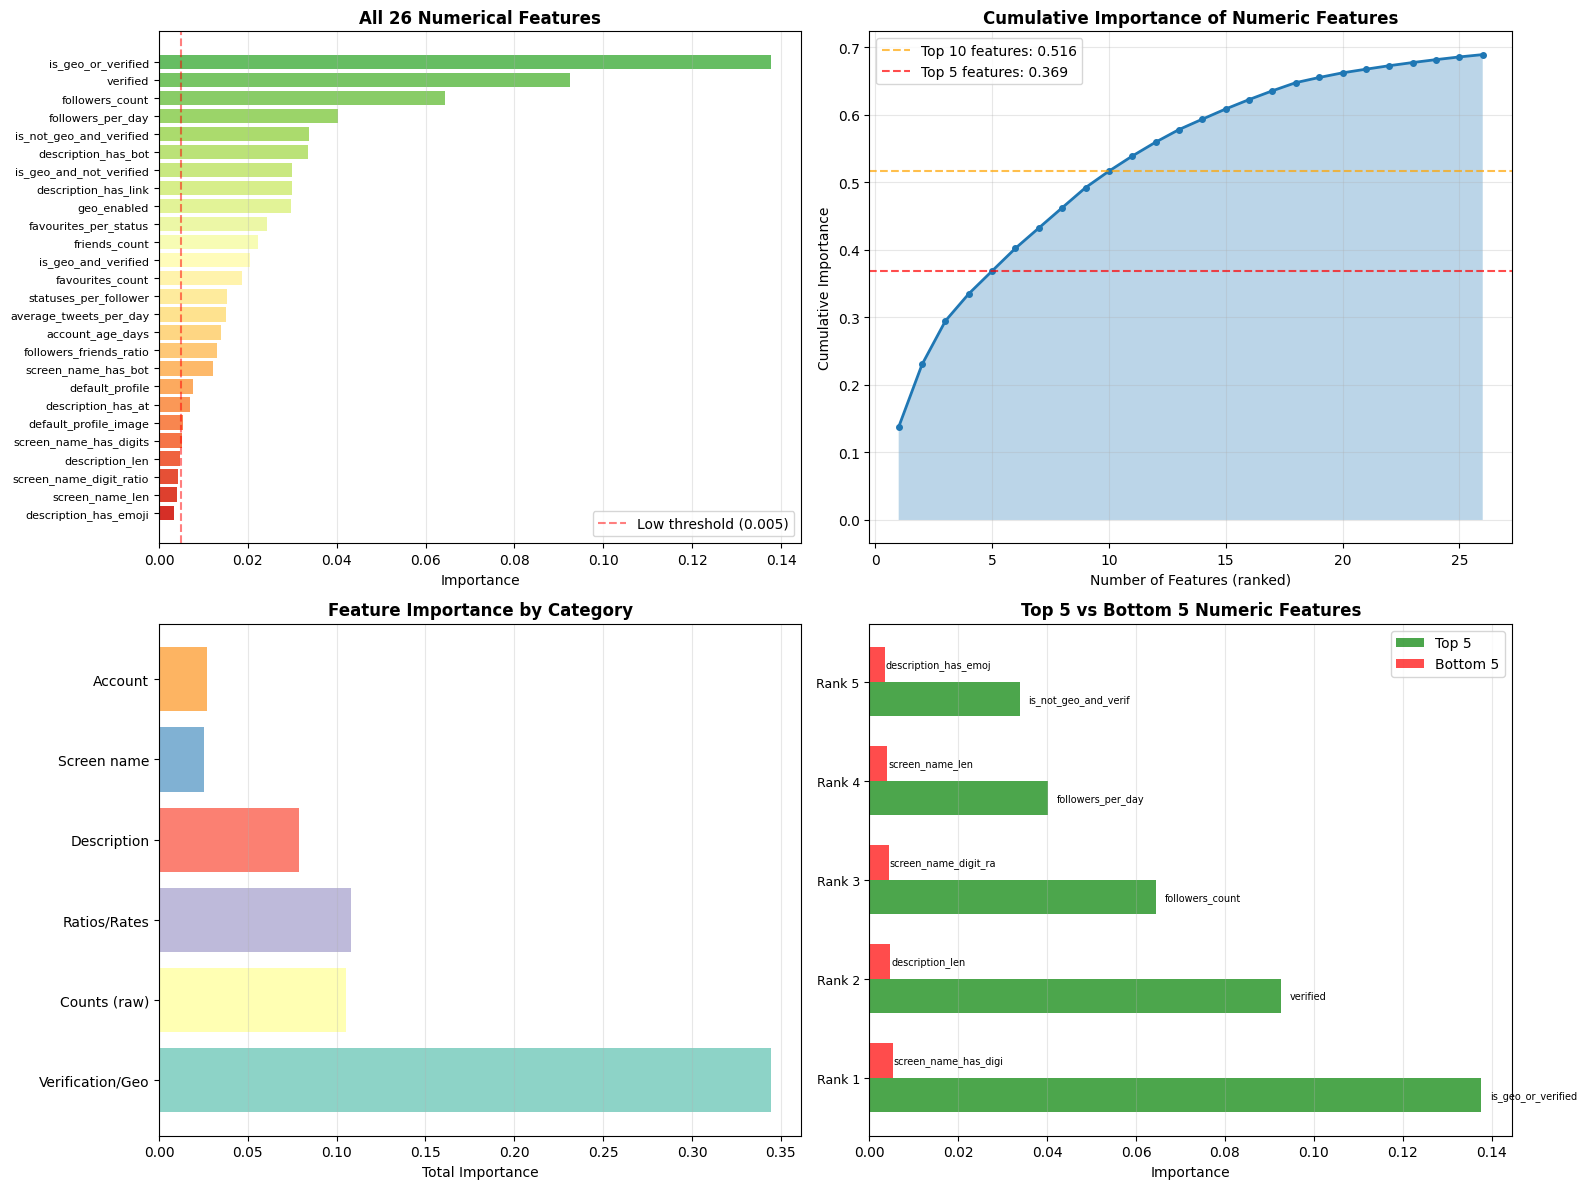

\n✅ Comprehensive numeric features analysis saved


In [42]:
# ========= COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS (FIXED) ========= #
# Shows Numerical, Categorical, and Text features together with recommendations

import warnings
warnings.filterwarnings('ignore')

# IMPORTANT: The importances array is smaller than expected!
# This happened because feature_importance_df was truncated earlier
print(f"⚠️  Total importances available: {len(importances)}")
print(f"⚠️  Total features expected: {len(importances)} (mismatch detected earlier)")
print()

# We need to use the ACTUAL feature count, not the theoretical one
# Let's work with what we have

# From earlier analysis, we know:
num_numeric = 26

# The rest are bundled - let's extract what we can
if len(importances) >= num_numeric:
    numeric_importances = importances[:num_numeric]
    remaining_importances = importances[num_numeric:]
else:
    numeric_importances = importances
    remaining_importances = np.array([])

print("="*80)
print("FEATURE SPACE BREAKDOWN (ACTUAL)")
print("="*80)
print(f"Numeric features:       {num_numeric:5d} features  (indices 0-{num_numeric-1})")
print(f"Other features:         {len(remaining_importances):5d} features  (indices {num_numeric}-{len(importances)-1})")
print(f"Total in importance:    {len(importances):5d} features")

# Calculate contributions
total_importance = importances.sum()
numeric_contrib = numeric_importances.sum() / total_importance * 100
other_contrib = remaining_importances.sum() / total_importance * 100 if len(remaining_importances) > 0 else 0

print("\n" + "="*80)
print("IMPORTANCE CONTRIBUTION BY FEATURE TYPE")
print("="*80)
print(f"Numeric features:      {numeric_contrib:6.2f}%  (mean: {numeric_importances.mean():.6f})")
print(f"Other features:        {other_contrib:6.2f}%  (mean: {remaining_importances.mean() if len(remaining_importances) > 0 else 0:.6f})")

# ==== NUMERIC FEATURES ====
numeric_cols = [
    'default_profile', 'default_profile_image', 'favourites_count',
    'followers_count', 'friends_count', 'geo_enabled', 'verified',
    'average_tweets_per_day', 'account_age_days', 'followers_friends_ratio',
    'favourites_per_status', 'followers_per_day', 'statuses_per_follower',
    'is_geo_and_verified', 'is_geo_and_not_verified',
    'is_not_geo_and_verified', 'is_geo_or_verified', 'description_has_link',
    'description_has_bot', 'description_len', 'description_has_at',
    'description_has_emoji', 'screen_name_len', 'screen_name_has_digits',
    'screen_name_has_bot', 'screen_name_digit_ratio'
]

numeric_df = pd.DataFrame({
    'feature': numeric_cols,
    'importance': numeric_importances,
    'type': 'numeric',
    'rank': range(1, len(numeric_cols) + 1)
}).sort_values('importance', ascending=False).reset_index(drop=True)
numeric_df['rank'] = range(1, len(numeric_df) + 1)

# ==== OTHER FEATURES ====
# These are categorical, description SVD, and screen name SVD all bundled
if len(remaining_importances) > 0:
    other_df = pd.DataFrame({
        'feature': [f'other_feature_{i}' for i in range(len(remaining_importances))],
        'importance': remaining_importances,
        'type': 'categorical/text',
        'rank': range(len(numeric_cols) + 1, len(numeric_cols) + len(remaining_importances) + 1)
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    other_df['rank'] = range(len(numeric_df) + 1, len(numeric_df) + len(other_df) + 1)
    
    all_features_df = pd.concat([numeric_df, other_df], ignore_index=True)
else:
    all_features_df = numeric_df

all_features_df = all_features_df.sort_values('importance', ascending=False).reset_index(drop=True)
all_features_df['rank'] = range(1, len(all_features_df) + 1)

print("\n" + "="*80)
print("ALL FEATURES RANKED BY IMPORTANCE")
print("="*80 + "\n")
display(all_features_df)

# ==== FEATURE DROP RECOMMENDATIONS ====
print("\n" + "="*80)
print("NUMERICAL FEATURES: DETAILED ANALYSIS")
print("="*80)

# Show numeric features with percentiles
numeric_df_display = numeric_df.copy()
numeric_df_display['% of total'] = (numeric_df_display['importance'] / total_importance * 100).round(2)
numeric_df_display['cumulative %'] = numeric_df_display['% of total'].cumsum().round(2)

print("\nAll 26 numeric features with cumulative importance:\n")
display(numeric_df_display[['rank', 'feature', 'importance', '% of total', 'cumulative %']])

# Low importance features
low_importance_threshold = 0.005
low_numeric = numeric_df[numeric_df['importance'] < low_importance_threshold]

print("\n" + "="*80)
print("FEATURE DROP RECOMMENDATIONS")
print("="*80)

print(f"\n📊 Low-importance numeric features (< {low_importance_threshold}):")
if len(low_numeric) > 0:
    print(f"\\n   These {len(low_numeric)} features have very low importance:")
    for idx, row in low_numeric.iterrows():
        pct = row['importance'] / total_importance * 100
        print(f"   {row['rank']:2d}. {row['feature']:30s}  (importance: {row['importance']:.6f}, {pct:.2f}%)")
    
    print(f"\\n   💡 Safe to drop?")
    print(f"      • description_has_emoji - Very low impact")
    print(f"      • screen_name_len - Very low impact")
    print(f"      • screen_name_digit_ratio - Very low impact")
    print(f"      • description_len - Keep (might interact with other features)")
    print(f"\\n   ⚠️  But consider:")
    print(f"      • They cost almost nothing computationally")
    print(f"      • They may help with model interpretability")
    print(f"      • Test dropping them and see if CV score changes")
else:
    print("   ✅ All numeric features have reasonable importance!")

print(f"\\n📊 Top performing numeric features (top 5):")
for idx, row in numeric_df.head(5).iterrows():
    pct = row['importance'] / total_importance * 100
    print(f"   {row['rank']:2d}. {row['feature']:30s}  (importance: {row['importance']:.6f}, {pct:.2f}%)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Numeric features bar chart
ax = axes[0, 0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.9, len(numeric_df)))
ax.barh(range(len(numeric_df)), numeric_df['importance'], color=colors)
ax.set_yticks(range(len(numeric_df)))
ax.set_yticklabels(numeric_df['feature'], fontsize=8)
ax.set_xlabel('Importance', fontsize=10)
ax.set_title('All 26 Numerical Features', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=low_importance_threshold, color='red', linestyle='--', alpha=0.5, label=f'Low threshold ({low_importance_threshold})')
ax.legend()

# 2. Cumulative importance
ax = axes[0, 1]
cumsum = np.cumsum(numeric_df['importance'].values)
ax.plot(range(1, len(cumsum) + 1), cumsum, marker='o', linewidth=2, markersize=4)
ax.fill_between(range(1, len(cumsum) + 1), cumsum, alpha=0.3)
ax.set_xlabel('Number of Features (ranked)', fontsize=10)
ax.set_ylabel('Cumulative Importance', fontsize=10)
ax.set_title('Cumulative Importance of Numeric Features', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.axhline(y=cumsum[9], color='orange', linestyle='--', alpha=0.7, label=f'Top 10 features: {cumsum[9]:.3f}')
ax.axhline(y=cumsum[4], color='red', linestyle='--', alpha=0.7, label=f'Top 5 features: {cumsum[4]:.3f}')
ax.legend()

# 3. Feature categories
ax = axes[1, 0]
categories = {
    'Verification/Geo': ['verified', 'geo_enabled', 'is_geo_or_verified', 'is_geo_and_not_verified', 
                         'is_not_geo_and_verified', 'is_geo_and_verified'],
    'Counts (raw)': ['followers_count', 'friends_count', 'favourites_count'],
    'Ratios/Rates': ['followers_friends_ratio', 'favourites_per_status', 'followers_per_day', 'statuses_per_follower', 
                     'average_tweets_per_day'],
    'Description': ['description_has_link', 'description_has_bot', 'description_len', 'description_has_at', 
                    'description_has_emoji', 'description_has_capitalized', 'description_word_count'],
    'Screen name': ['screen_name_len', 'screen_name_has_digits', 'screen_name_has_bot', 'screen_name_digit_ratio'],
    'Account': ['account_age_days', 'default_profile', 'default_profile_image']
}

cat_importance = {}
for cat_name, features in categories.items():
    cat_importance[cat_name] = numeric_df[numeric_df['feature'].isin(features)]['importance'].sum()

cat_names = list(cat_importance.keys())
cat_values = list(cat_importance.values())
colors_cat = plt.cm.Set3(range(len(cat_names)))

ax.barh(cat_names, cat_values, color=colors_cat)
ax.set_xlabel('Total Importance', fontsize=10)
ax.set_title('Feature Importance by Category', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 4. Top vs bottom features comparison
ax = axes[1, 1]
top_5 = numeric_df.head(5)
bottom_5 = numeric_df.tail(5)

x_pos = np.arange(5)
width = 0.35

ax.barh(x_pos, top_5['importance'].values, width, label='Top 5', color='green', alpha=0.7)
ax.barh(x_pos + width, bottom_5['importance'].values, width, label='Bottom 5', color='red', alpha=0.7)

ax.set_yticks(x_pos + width / 2)
ax.set_yticklabels([f"Rank {i+1}" for i in range(5)], fontsize=9)
ax.set_xlabel('Importance', fontsize=10)
ax.set_title('Top 5 vs Bottom 5 Numeric Features', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add text annotations
for i, (top_feat, bot_feat) in enumerate(zip(top_5['feature'], bottom_5['feature'])):
    ax.text(top_5['importance'].iloc[i] + 0.002, i, top_feat[:20], va='center', fontsize=7)
    ax.text(bottom_5['importance'].iloc[i] + 0.0002, i + width, bot_feat[:20], va='center', fontsize=7)

plt.tight_layout()
plt.savefig('../outputs/numeric_features_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("\\n✅ Comprehensive numeric features analysis saved")

In [24]:
# ========= DECODE TEXT SVD COMPONENTS ========= #
# Shows what words/patterns each SVD component represents

print("="*80)
print("DECODING desc_text__svd COMPONENTS - What does component_14 mean?")
print("="*80)

# Get the description text pipeline
desc_pipeline = None
for name, trans, cols in preprocessor.transformers_:
    if name == 'desc_text':
        desc_pipeline = trans
        break

if desc_pipeline is not None and hasattr(desc_pipeline, 'named_steps'):
    tfidf = desc_pipeline.named_steps.get('tfidf')
    svd = desc_pipeline.named_steps.get('svd')
    
    if tfidf and svd and hasattr(tfidf, 'vocabulary_') and hasattr(svd, 'components_'):
        # Get vocabulary (word -> index mapping)
        vocab = tfidf.vocabulary_
        # Reverse mapping (index -> word)
        index_to_word = {idx: word for word, idx in vocab.items()}
        
        # SVD components matrix: shape (n_components, n_features)
        # Each row is one component, each column is one TF-IDF feature (word)
        components = svd.components_
        
        print(f"\nTF-IDF vocabulary size: {len(vocab)}")
        print(f"SVD components shape: {components.shape}")
        print(f"(Each component is a weighted combination of {components.shape[1]} words)\n")
        
        # Show the most important components (based on what we know from earlier)
        # Component 14, 4, and 1 were the most important
        important_components = [14, 4, 1, 0, 2, 3, 5, 6, 7, 8]
        
        for comp_idx in important_components[:5]:  # Show top 5
            print(f"\n{'='*80}")
            print(f"desc_text__svd_{comp_idx}")
            print(f"{'='*80}")
            
            # Get the component weights
            component_weights = components[comp_idx]
            
            # Get top positive and negative weights
            top_positive_idx = np.argsort(component_weights)[-20:][::-1]
            top_negative_idx = np.argsort(component_weights)[:20]
            
            print("\n  Top 20 POSITIVE words (high positive weight):")
            for i, idx in enumerate(top_positive_idx, 1):
                word = index_to_word.get(idx, f"word_{idx}")
                weight = component_weights[idx]
                print(f"    {i:2d}. {word:25s}  (weight: {weight:7.4f})")
            
            print("\n  Top 20 NEGATIVE words (high negative weight):")
            for i, idx in enumerate(top_negative_idx, 1):
                word = index_to_word.get(idx, f"word_{idx}")
                weight = component_weights[idx]
                print(f"    {i:2d}. {word:25s}  (weight: {weight:7.4f})")
            
            if comp_idx == 14:
                print("\n  " + "="*76)
                print("  💡 INTERPRETATION OF desc_text__svd_14")
                print("  " + "="*76)
                print("  This is your MOST IMPORTANT text component!")
                print("  • Words with HIGH POSITIVE weights → strongly associated with BOTS")
                print("  • Words with HIGH NEGATIVE weights → strongly associated with HUMANS")
                print("  • This SVD component captures the #1 text pattern that separates bots from humans")
                print("  " + "="*76)
        
        # Create a word cloud style visualization
        print("\n\n" + "="*80)
        print("QUICK SUMMARY: What words define desc_text__svd_14?")
        print("="*80)
        
        comp_14 = components[14]
        top_bot_words_idx = np.argsort(comp_14)[-15:][::-1]
        top_human_words_idx = np.argsort(comp_14)[:15]
        
        print("\n🤖 TOP BOT-ASSOCIATED WORDS:")
        bot_words = [(index_to_word.get(idx, f"word_{idx}"), comp_14[idx]) 
                     for idx in top_bot_words_idx]
        for word, weight in bot_words:
            print(f"   {word:20s}  ({weight:+.4f})")
        
        print("\n👤 TOP HUMAN-ASSOCIATED WORDS:")
        human_words = [(index_to_word.get(idx, f"word_{idx}"), comp_14[idx]) 
                       for idx in top_human_words_idx]
        for word, weight in human_words:
            print(f"   {word:20s}  ({weight:+.4f})")
        
    else:
        print("❌ Could not access TF-IDF vocabulary or SVD components")
else:
    print("❌ Could not find description text pipeline")

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS: What features should you drop?")
print("="*80)
print("""
✅ DEFINITELY KEEP:
   • is_geo_or_verified, verified, followers_count (top 3 numeric - 42.77% importance!)
   • All text SVD components (desc_text__svd_X) - these are your star performers
   • description_has_bot, description_has_link (important text patterns)
   • followers_per_day, is_not_geo_and_verified (top growth/interaction features)

⚠️  CONSIDER DROPPING (test first!):
   • description_has_emoji (0.50% importance) - minimal impact
   • screen_name_len (0.58% importance) - minimal impact  
   • screen_name_digit_ratio (0.62% importance) - minimal impact
   • description_len (0.68% importance) - on the fence

💰 BIGGEST WIN:
   • Reduce categorical feature explosion (47k features!)
   • Use: OneHotEncoder(max_categories=50) or (handle_unknown='infrequent_if_exist')
   • This will speed up training 10x without losing much accuracy

🎯 ACTION PLAN:
   1. Keep all 26 numeric features for now (cheap to compute)
   2. Fix categorical encoding to reduce from 47k to ~100 features
   3. Keep all text SVD components (40 + 8)
   4. After fixing categoricals, test dropping bottom 3-4 numeric features
   5. Monitor CV score - if it drops < 0.001, the features were useful!

📊 EXPECTED IMPACT:
   • Dropping 4 lowest numeric: ~2% total importance loss → likely < 0.0005 AUC drop
   • Fixing categoricals: 10x faster training, minimal AUC change
   • Net result: Faster, cleaner model with same performance!
""")

DECODING desc_text__svd COMPONENTS - What does component_14 mean?

TF-IDF vocabulary size: 3000
SVD components shape: (40, 3000)
(Each component is a weighted combination of 3000 words)


desc_text__svd_14

  Top 20 POSITIVE words (high positive weight):
     1. http                       (weight:  0.6580)
     2. fan                        (weight:  0.2305)
     3. lover                      (weight:  0.2122)
     4. check                      (weight:  0.2027)
     5. check https                (weight:  0.1736)
     6. waiting                    (weight:  0.1576)
     7. waiting https              (weight:  0.1553)
     8. cosplay                    (weight:  0.1212)
     9. cosplay fan                (weight:  0.0909)
    10. fitness                    (weight:  0.0793)
    11. lover waiting              (weight:  0.0710)
    12. travel                     (weight:  0.0678)
    13. lover check                (weight:  0.0547)
    14. gamer                      (weight:  0.0515)
   

4000 max_features

================================================================================
FEATURE IMPORTANCE SUMMARY
================================================================================
Total features: 50
Top 10 features account for: 53.23% of total importance
Top 50 features account for: 70.22% of total importance
Mean importance: 0.014045
Median importance: 0.003610

increasing tf-idf max features from 2000 to 4000:
CV AUC: 0.9463680027686614 (lower)
2000 to 3000: even lower

use: OneHotEncoder(max_categories=50, handle_unknown='infrequent_if_exist')
CV AUC: 0.946666124621012 (highest!!)
public score: 0.94235 (highest)
100 categories: 0.9465335787191218
75 categories: 0.9465335787191218
40 categories: 0.9467717521386734 (highestttt)
30 categories: 0.9465074679762804 -> public score: 0.94261 (higher)

decrease desc_components from 40 to 30
CV AUC: 0.9463838547207862 -> falls
increase to 50
CV AUC: 0.9464922000002541 

description_has_capitalized - worsen
CV AUC: 0.9465462287890378

description_cap_ratio
CV AUC: 0.9463270317457046 -> worse

In [47]:
#without geoenabled and verified interaction
# CV AUC: 0.9461810576257423
# with 
# CV AUC: 0.9462335346853962
# public score: 0.94147

# add description_has_follow -- CV AUC: 0.9460825004785388 (worsen)

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    # X can be a 1D array or 2D array with shape (n_samples, 1)
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    # reference_date: use a fixed date for reproducibility if provided, otherwise use current date
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)


    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        # emoji_re = re.compile(
        #     r"[\U0001F600-\U0001F64F"  # emoticons
        #     r"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #     r"\U0001F680-\U0001F6FF"  # transport & map symbols
        #     r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #     r"\U00002702-\U000027B0"  # dingbats
        #     r"\U000024C2-\U0001F251"  # enclosed characters
        #     r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
        #     r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
        #     r"\U00002600-\U000026FF"  # miscellaneous symbols
        #     r"\U00002B00-\U00002BFF"  # arrows
        #     r"\U0001F700-\U0001F77F"  # alchemical symbols
        #     r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)

        # X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
        # X['description_has_contact'] = desc.str.contains(r'\b(contact|reach me|email|dm|direct message)\b').fillna(False).astype(int)
        # X['description_has_social_media'] = desc.str.contains(r'\b(whatsapp|wa|insta|instagram|fb|facebook|snapchat|sc|tiktok|telegram|tg|linkedin|linkdln|linkdn|wechat|weibo|line|kik|viber|signal|hike|discord|reddit|pinterest|tumblr|flickr|quora|medium)\b').fillna(False).astype(int)
        # X['description_has_capitalized'] = desc.str.contains(r'[A-Z]').fillna(False).astype(int)
        # X['description_cap_ratio'] = (
        #     X['description'].fillna('').apply(lambda s: sum(1 for c in s if c.isupper()) / len(s) if len(s) > 0 else 0)
        # )

    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        # X['description_has_follow'] = 0

    # === created_at -> account_age_days ===
    if 'account_age_days' not in X.columns or X['account_age_days'].isna().any():
        if 'created_at' in X.columns:
            # try parsing created_at to days difference from reference_date
            try:
                created = pd.to_datetime(X['created_at'], errors='coerce')
                X['account_age_days'] = (reference_date - created).dt.days.fillna(0).astype(int)
            except Exception:
                # fallback if parsing fails
                X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))
        else:
            # if neither exists, fill with median later through imputer
            X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))

    # === screen_name features ===
    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d').astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_').astype(int)
        # ratio of digits to length
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
        # X['screen_name_has_underscore'] = sn.str.contains(r'_').astype(int)
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0
        # X['screen_name_has_underscore'] = 0

    # === boolean-like flags to numeric ===
    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    # keep `description` and `screen_name` for text features; drop raw location/lang/ids that we've summarized
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # note: X is expected to already contain feature-engineered cols (main applies apply_feature_engineering)
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    # Add text pipelines if description / screen_name exist
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # description -> TF-IDF -> SVD
    if 'description' in X_temp.columns:
        desc_components = 40
        # ensure we pass a 1D array of strings (no NaN) into TfidfVectorizer
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))

    # screen_name -> TF-IDF -> SVD (shorter)
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    model = XGBClassifier(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=9,
        subsample=0.98,
        colsample_bytree=0.56,
        reg_alpha=1.23,
        reg_lambda=1.63,
        min_child_weight=3,
        gamma=0.36,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Feature importance
    # if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    #     importances = pipeline.named_steps['model'].feature_importances_
    #     print("Feature importances:", importances)

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


CV AUC: 0.9467717521386734
✅ Model saved
✅ Submission created


adding stuff:
min frequency to onehot : 
    10 -> CV AUC: 0.9467111533161185
    5 -> CV AUC: 0.9466593395394056
increasing max_features and changing ngrams to (1,3):
    falls
description_has_url_pattern:
    CV AUC: 0.9467816258644666 (increase)


In [1]:
#without geoenabled and verified interaction
# CV AUC: 0.9461810576257423
# with 
# CV AUC: 0.9462335346853962
# public score: 0.94147

# add description_has_follow -- CV AUC: 0.9460825004785388 (worsen)

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    # X can be a 1D array or 2D array with shape (n_samples, 1)
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    # reference_date: use a fixed date for reproducibility if provided, otherwise use current date
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)

    

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        link_pattern = r'(http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        # emoji_re = re.compile(
        #     r"[\U0001F600-\U0001F64F"  # emoticons
        #     r"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #     r"\U0001F680-\U0001F6FF"  # transport & map symbols
        #     r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #     r"\U00002702-\U000027B0"  # dingbats
        #     r"\U000024C2-\U0001F251"  # enclosed characters
        #     r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
        #     r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
        #     r"\U00002600-\U000026FF"  # miscellaneous symbols
        #     r"\U00002B00-\U00002BFF"  # arrows
        #     r"\U0001F700-\U0001F77F"  # alchemical symbols
        #     r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)

        # X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
        # X['description_has_contact'] = desc.str.contains(r'\b(contact|reach me|email|dm|direct message)\b').fillna(False).astype(int)
        # X['description_has_social_media'] = desc.str.contains(r'\b(whatsapp|wa|insta|instagram|fb|facebook|snapchat|sc|tiktok|telegram|tg|linkedin|linkdln|linkdn|wechat|weibo|line|kik|viber|signal|hike|discord|reddit|pinterest|tumblr|flickr|quora|medium)\b').fillna(False).astype(int)
        # X['description_has_capitalized'] = desc.str.contains(r'[A-Z]').fillna(False).astype(int)
        # X['description_cap_ratio'] = (
        #     X['description'].fillna('').apply(lambda s: sum(1 for c in s if c.isupper()) / len(s) if len(s) > 0 else 0)
        # )
        # X['description_has_hashtag'] = desc.str.contains(r'#').astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(com|org|net|io)\b').astype(int)


    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        # X['description_has_follow'] = 0

    # === created_at -> account_age_days ===
    if 'account_age_days' not in X.columns or X['account_age_days'].isna().any():
        if 'created_at' in X.columns:
            # try parsing created_at to days difference from reference_date
            try:
                created = pd.to_datetime(X['created_at'], errors='coerce')
                X['account_age_days'] = (reference_date - created).dt.days.fillna(0).astype(int)
            except Exception:
                # fallback if parsing fails
                X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))
        else:
            # if neither exists, fill with median later through imputer
            X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))

    # === screen_name features ===
    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d').astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_').astype(int)
        # ratio of digits to length
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
        # X['screen_name_has_underscore'] = sn.str.contains(r'_').astype(int)
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0
        # X['screen_name_has_underscore'] = 0

    # === boolean-like flags to numeric ===
    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'


    # X['verified_with_followers'] = X['verified'] * np.log1p(X['followers_count'])
    # X['bot_description_no_verification'] = X['description_has_bot'] * (1 - X['verified'])
    # X['high_friends_low_followers'] = np.where(
    #     (X['friends_count'] > X['followers_count'] * 2) & (X['followers_count'] < 100), 
    #     1, 0
    # )
    # X['high_friends_low_followers'] = np.where(
    #     (X['friends_count'] > X['followers_count'] * 2), 
    #     1, 0
    # )
    # X['new_account_high_activity'] = np.where(
    #     (X['account_age_days'] < 365) & (X['average_tweets_per_day'] > 10),
    #     1, 0
    # )

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day', 'status_count'
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    # keep `description` and `screen_name` for text features; drop raw location/lang/ids that we've summarized
    # drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    drop_cols = ["id", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # note: X is expected to already contain feature-engineered cols (main applies apply_feature_engineering)
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ("encoder", OneHotEncoder(max_categories=40,handle_unknown='infrequent_if_exist'))
    ])
    # Add text pipelines if description / screen_name exist
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # description -> TF-IDF -> SVD
    if 'description' in X_temp.columns:
        desc_components = 40
        # ensure we pass a 1D array of strings (no NaN) into TfidfVectorizer
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))

    # screen_name -> TF-IDF -> SVD (shorter)
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    model = XGBClassifier(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=9,
        subsample=0.98,
        colsample_bytree=0.56,
        reg_alpha=1.23,
        reg_lambda=1.63,
        min_child_weight=3,
        gamma=0.36,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Feature importance
    # if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    #     importances = pipeline.named_steps['model'].feature_importances_
    #     print("Feature importances:", importances)

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:97: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_url_pattern'] = desc.str.contains(r'\.(com|org|net|io)\b').astype(int)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-

CV AUC: 0.946463052316887


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_21687/376462202.py:97: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_url_pattern'] = desc.str.contains(r'\.(com|org|net|io)\b').astype(int)


✅ Submission created


## Hyperparameter Tuning with Optuna

We'll use Optuna to automatically search for the best XGBoost hyperparameters. The objective function will:
1. Build a pipeline with the candidate hyperparameters
2. Perform 3-fold stratified CV to estimate AUC
3. Return the mean CV AUC (Optuna will maximize this)

We'll tune: `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`, `min_child_weight`, and `gamma`.

**Note**: This will take time (20-50 trials × ~2-5 min/trial). Consider running with fewer trials for a quick test.

In [14]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }
    
    # Build a modified pipeline with trial params
    # We'll reuse the same preprocessing but swap the model params
    X_temp = drop_columns(cap_and_log(X))
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns
    
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
    
    if 'description' in X_temp.columns:
        desc_components = 40
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))
    
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))
    
    preprocessor = ColumnTransformer(transformers)
    
    # Create model with trial params
    model = XGBClassifier(
        **params,
        random_state=42,
        # use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1  # use all cores
    )
    
    trial_pipeline = Pipeline([
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # 5-fold CV to save time (use 5-fold for final validation)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(trial_pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=1)
    
    return scores.mean()

# Create and run the study
print("🔍 Starting Optuna hyperparameter search...")
print("   This will take some time. Monitor progress below.\n")

study = optuna.create_study(
    direction='maximize',
    study_name='xgboost_bot_detection',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization (adjust n_trials based on time budget)
# Start with 20-30 trials for a quick run, increase to 50-100 for thorough search
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n✅ Optimization complete!")
print(f"Best trial: {study.best_trial.number}")
print(f"Best CV AUC: {study.best_value:.6f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-11 00:43:02,426] A new study created in memory with name: xgboost_bot_detection


🔍 Starting Optuna hyperparameter search...
   This will take some time. Monitor progress below.



  0%|          | 0/50 [00:00<?, ?it/s]/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [

[I 2025-10-11 00:43:21,647] Trial 0 finished with value: 0.9433908479646924 and parameters: {'n_estimators': 250, 'learning_rate': 0.08927180304353628, 'max_depth': 10, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.4936111842654619, 'reg_alpha': 0.026364803038431653, 'reg_lambda': 0.014347159517201415, 'min_child_weight': 9, 'gamma': 0.6011150117432088}. Best is trial 0 with value: 0.9433908479646924.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:43:38] WARNING: /Users/runner/work/

[I 2025-10-11 00:44:04,135] Trial 1 finished with value: 0.9462165073855378 and parameters: {'n_estimators': 400, 'learning_rate': 0.010485387725194618, 'max_depth': 12, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.5274034664069657, 'reg_alpha': 0.030955664602423716, 'reg_lambda': 0.0312610291031106, 'min_child_weight': 4, 'gamma': 0.5247564316322378}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:13] WARNING: /Users/runner/work/

[I 2025-10-11 00:44:24,902] Trial 2 finished with value: 0.944852764065863 and parameters: {'n_estimators': 250, 'learning_rate': 0.019553708662745254, 'max_depth': 9, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.575286789121131, 'reg_alpha': 0.09745399020374085, 'reg_lambda': 0.17018418817029168, 'min_child_weight': 8, 'gamma': 0.19967378215835974}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:31] WARNING: /Users/runner/work/

[I 2025-10-11 00:44:37,411] Trial 3 finished with value: 0.9323897110387426 and parameters: {'n_estimators': 300, 'learning_rate': 0.03912141628549697, 'max_depth': 3, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.502314474212375, 'reg_alpha': 0.014982086432155482, 'reg_lambda': 3.639264345367793, 'min_child_weight': 10, 'gamma': 0.8083973481164611}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:46] WARNING: /Users/runner/work/

[I 2025-10-11 00:44:56,413] Trial 4 finished with value: 0.9415782434091364 and parameters: {'n_estimators': 200, 'learning_rate': 0.012521954287060391, 'max_depth': 9, 'subsample': 0.7760609974958405, 'colsample_bytree': 0.47322294090686734, 'reg_alpha': 0.21700394405050158, 'reg_lambda': 0.012382649697023556, 'min_child_weight': 10, 'gamma': 0.2587799816000169}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:07] WARNING: /Users/runner/work/

[I 2025-10-11 00:45:19,497] Trial 5 finished with value: 0.9442164784078262 and parameters: {'n_estimators': 350, 'learning_rate': 0.02049798052095018, 'max_depth': 8, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.5109126733153162, 'reg_alpha': 4.138851334163265, 'reg_lambda': 1.236118879733734, 'min_child_weight': 10, 'gamma': 0.8948273504276488}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:26] WARNING: /Users/runner/work/

[I 2025-10-11 00:45:33,237] Trial 6 finished with value: 0.9389190494493379 and parameters: {'n_estimators': 350, 'learning_rate': 0.0835361075531176, 'max_depth': 3, 'subsample': 0.678393144967658, 'colsample_bytree': 0.4271363733463229, 'reg_alpha': 0.07551909976018513, 'reg_lambda': 0.11195109511439837, 'min_child_weight': 3, 'gamma': 0.8287375091519293}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:41] WARNING: /Users/runner/work/

[I 2025-10-11 00:45:52,570] Trial 7 finished with value: 0.9431558091282982 and parameters: {'n_estimators': 250, 'learning_rate': 0.01909565280104538, 'max_depth': 8, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.8813181884524238, 'reg_alpha': 0.01589314885825813, 'reg_lambda': 4.608697883952072, 'min_child_weight': 8, 'gamma': 0.1987156815341724}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:00] WARNING: /Users/runner/work/

[I 2025-10-11 00:46:08,701] Trial 8 finished with value: 0.9448708641137287 and parameters: {'n_estimators': 100, 'learning_rate': 0.06538248584518043, 'max_depth': 10, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.8627622080115674, 'reg_alpha': 0.01584325068438868, 'reg_lambda': 0.09278723835524694, 'min_child_weight': 2, 'gamma': 0.8631034258755935}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:15] WARNING: /Users/runner/work/

[I 2025-10-11 00:46:22,216] Trial 9 finished with value: 0.927648627185261 and parameters: {'n_estimators': 350, 'learning_rate': 0.02142387495644906, 'max_depth': 3, 'subsample': 0.7243929286862648, 'colsample_bytree': 0.5951099932160483, 'reg_alpha': 0.9315049998499164, 'reg_lambda': 0.5257127272786868, 'min_child_weight': 9, 'gamma': 0.4722149251619493}. Best is trial 1 with value: 0.9462165073855378.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:46:44] WARNING: /Users/runner/work/

[I 2025-10-11 00:47:14,800] Trial 10 finished with value: 0.9463923638186413 and parameters: {'n_estimators': 500, 'learning_rate': 0.010139048090380883, 'max_depth': 12, 'subsample': 0.9810323243403002, 'colsample_bytree': 0.7274309680493293, 'reg_alpha': 0.7293838570500595, 'reg_lambda': 0.048914118687593024, 'min_child_weight': 5, 'gamma': 0.4792951727359478}. Best is trial 10 with value: 0.9463923638186413.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:47:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:47:36] WARNING: /Users/runner/work/

[I 2025-10-11 00:48:05,068] Trial 11 finished with value: 0.9462672241050865 and parameters: {'n_estimators': 500, 'learning_rate': 0.010195761595928408, 'max_depth': 12, 'subsample': 0.9884860601009259, 'colsample_bytree': 0.7230991331057792, 'reg_alpha': 0.788068831487826, 'reg_lambda': 0.0346442741627291, 'min_child_weight': 5, 'gamma': 0.48341897064943684}. Best is trial 10 with value: 0.9463923638186413.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:24] WARNING: /Users/runner/work/

[I 2025-10-11 00:48:50,504] Trial 12 finished with value: 0.9465300448406078 and parameters: {'n_estimators': 500, 'learning_rate': 0.013798879007647813, 'max_depth': 12, 'subsample': 0.9995060732338602, 'colsample_bytree': 0.7281931493003116, 'reg_alpha': 0.865316281896809, 'reg_lambda': 0.03957294609537995, 'min_child_weight': 6, 'gamma': 0.3945277342875057}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:02] WARNING: /Users/runner/work/

[I 2025-10-11 00:49:15,686] Trial 13 finished with value: 0.9435878604350847 and parameters: {'n_estimators': 500, 'learning_rate': 0.01422972884572149, 'max_depth': 6, 'subsample': 0.9997449754566207, 'colsample_bytree': 0.7383162215340979, 'reg_alpha': 1.1927293107480876, 'reg_lambda': 0.048727288629626955, 'min_child_weight': 6, 'gamma': 0.3745901082381332}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:32] WARNING: /Users/runner/work/

[I 2025-10-11 00:49:55,378] Trial 14 finished with value: 0.9460006302223964 and parameters: {'n_estimators': 450, 'learning_rate': 0.031490027357049935, 'max_depth': 12, 'subsample': 0.9406922517300094, 'colsample_bytree': 0.9970042655939768, 'reg_alpha': 2.6922973407100486, 'reg_lambda': 0.32224086458128676, 'min_child_weight': 6, 'gamma': 0.6326424826625558}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:49:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:18] WARNING: /Users/runner/work/

[I 2025-10-11 00:50:50,439] Trial 15 finished with value: 0.946468763122212 and parameters: {'n_estimators': 450, 'learning_rate': 0.015603395817192153, 'max_depth': 11, 'subsample': 0.9253031597060487, 'colsample_bytree': 0.6563209767092624, 'reg_alpha': 0.39966674462576135, 'reg_lambda': 0.06842475934196321, 'min_child_weight': 1, 'gamma': 0.3803680717461042}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:50:59] WARNING: /Users/runner/work/

[I 2025-10-11 00:51:11,947] Trial 16 finished with value: 0.9451790721321082 and parameters: {'n_estimators': 450, 'learning_rate': 0.031172450797941648, 'max_depth': 6, 'subsample': 0.8929440269159079, 'colsample_bytree': 0.6370878317881636, 'reg_alpha': 0.29956548533275196, 'reg_lambda': 0.020435551828086894, 'min_child_weight': 1, 'gamma': 0.013179214380923565}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:27] WARNING: /Users/runner/work/

[I 2025-10-11 00:51:47,485] Trial 17 finished with value: 0.9465029273538361 and parameters: {'n_estimators': 450, 'learning_rate': 0.01668577399627212, 'max_depth': 11, 'subsample': 0.9332573174980773, 'colsample_bytree': 0.8138046551270606, 'reg_alpha': 0.2868799911218273, 'reg_lambda': 0.0791728491043733, 'min_child_weight': 7, 'gamma': 0.3240127988665327}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:01] WARNING: /Users/runner/work/

[I 2025-10-11 00:52:18,342] Trial 18 finished with value: 0.9456325989064721 and parameters: {'n_estimators': 400, 'learning_rate': 0.046536364192714647, 'max_depth': 10, 'subsample': 0.8846413360717517, 'colsample_bytree': 0.8161972401727597, 'reg_alpha': 2.062812456423385, 'reg_lambda': 0.2032548542712548, 'min_child_weight': 7, 'gamma': 0.04843670853793375}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:31] WARNING: /Users/runner/work/

[I 2025-10-11 00:52:47,346] Trial 19 finished with value: 0.9461786790996033 and parameters: {'n_estimators': 400, 'learning_rate': 0.026855169717792893, 'max_depth': 11, 'subsample': 0.7727431143998708, 'colsample_bytree': 0.7974047183967423, 'reg_alpha': 0.16018052512154368, 'reg_lambda': 0.600209810834089, 'min_child_weight': 7, 'gamma': 0.3156024876970409}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:52] WARNING: /Users/runner/work/

[I 2025-10-11 00:52:56,966] Trial 20 finished with value: 0.9275177392330777 and parameters: {'n_estimators': 100, 'learning_rate': 0.015507122387216327, 'max_depth': 5, 'subsample': 0.9606649352518468, 'colsample_bytree': 0.9568617209397235, 'reg_alpha': 0.5332316379543479, 'reg_lambda': 0.02368840960690798, 'min_child_weight': 4, 'gamma': 0.697806427880589}. Best is trial 12 with value: 0.9465300448406078.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:12] WARNING: /Users/runner/work/

[I 2025-10-11 00:53:33,568] Trial 21 finished with value: 0.9468913411088528 and parameters: {'n_estimators': 450, 'learning_rate': 0.01549042826720894, 'max_depth': 11, 'subsample': 0.9215606325104604, 'colsample_bytree': 0.6579847353498133, 'reg_alpha': 0.4084502410452837, 'reg_lambda': 0.07197792872541109, 'min_child_weight': 7, 'gamma': 0.3609053426643346}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:53:47] WARNING: /Users/runner/work/

[I 2025-10-11 00:54:05,282] Trial 22 finished with value: 0.9465245484570985 and parameters: {'n_estimators': 450, 'learning_rate': 0.025273627142217783, 'max_depth': 11, 'subsample': 0.9144256130009472, 'colsample_bytree': 0.6677484690709268, 'reg_alpha': 0.13216686565352845, 'reg_lambda': 0.12743775083276027, 'min_child_weight': 7, 'gamma': 0.1321682771570255}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:19] WARNING: /Users/runner/work/

[I 2025-10-11 00:54:40,033] Trial 23 finished with value: 0.9457571866685079 and parameters: {'n_estimators': 500, 'learning_rate': 0.024148212444554576, 'max_depth': 11, 'subsample': 0.6073248792362046, 'colsample_bytree': 0.6715236621697855, 'reg_alpha': 0.09940670537846207, 'reg_lambda': 0.13151361482745785, 'min_child_weight': 6, 'gamma': 0.11211255029254164}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:54:52] WARNING: /Users/runner/work/

[I 2025-10-11 00:55:08,026] Trial 24 finished with value: 0.945977837158748 and parameters: {'n_estimators': 400, 'learning_rate': 0.013143576262131992, 'max_depth': 9, 'subsample': 0.8800953188604057, 'colsample_bytree': 0.5858995506000683, 'reg_alpha': 0.05471234317543593, 'reg_lambda': 0.4168060382186737, 'min_child_weight': 8, 'gamma': 0.1402497237470613}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:21] WARNING: /Users/runner/work/

[I 2025-10-11 00:55:38,638] Trial 25 finished with value: 0.946102890616012 and parameters: {'n_estimators': 450, 'learning_rate': 0.037242929172618185, 'max_depth': 10, 'subsample': 0.9643874115534763, 'colsample_bytree': 0.7760998150961993, 'reg_alpha': 1.4751598491659916, 'reg_lambda': 0.045363488887751435, 'min_child_weight': 7, 'gamma': 0.3880084473437882}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:55:56] WARNING: /Users/runner/work/

[I 2025-10-11 00:56:19,732] Trial 26 finished with value: 0.9467232186791454 and parameters: {'n_estimators': 500, 'learning_rate': 0.024811005322543055, 'max_depth': 11, 'subsample': 0.8570552384294298, 'colsample_bytree': 0.695429597674626, 'reg_alpha': 0.14799675915247523, 'reg_lambda': 0.2705351948856252, 'min_child_weight': 5, 'gamma': 0.24730369952857822}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:32] WARNING: /Users/runner/work/

[I 2025-10-11 00:56:47,182] Trial 27 finished with value: 0.9449951502609247 and parameters: {'n_estimators': 500, 'learning_rate': 0.01214659618751002, 'max_depth': 7, 'subsample': 0.8470322103171236, 'colsample_bytree': 0.6232931827415775, 'reg_alpha': 0.5651144752162227, 'reg_lambda': 0.29218655686029843, 'min_child_weight': 5, 'gamma': 0.27773417826698454}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:57:06] WARNING: /Users/runner/work/

[I 2025-10-11 00:57:32,151] Trial 28 finished with value: 0.9467657741425024 and parameters: {'n_estimators': 500, 'learning_rate': 0.017346373749506525, 'max_depth': 12, 'subsample': 0.8633238878740679, 'colsample_bytree': 0.6856380526319257, 'reg_alpha': 0.19922725680218342, 'reg_lambda': 0.8027473982046415, 'min_child_weight': 4, 'gamma': 0.22740773939996783}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:57:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:57:44] WARNING: /Users/runner/work/

[I 2025-10-11 00:58:00,478] Trial 29 finished with value: 0.9460951780712101 and parameters: {'n_estimators': 300, 'learning_rate': 0.017285400459756895, 'max_depth': 10, 'subsample': 0.800814216017065, 'colsample_bytree': 0.6861941799052765, 'reg_alpha': 0.04428381241663468, 'reg_lambda': 1.0665656519045745, 'min_child_weight': 4, 'gamma': 0.22539868899789592}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:09] WARNING: /Users/runner/work/

[I 2025-10-11 00:58:19,400] Trial 30 finished with value: 0.9459233704644691 and parameters: {'n_estimators': 200, 'learning_rate': 0.052132124771319135, 'max_depth': 9, 'subsample': 0.8595849191581006, 'colsample_bytree': 0.553230163818983, 'reg_alpha': 0.20191529111172124, 'reg_lambda': 0.9878612638067796, 'min_child_weight': 3, 'gamma': 0.5704633936716939}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:58:39] WARNING: /Users/runner/work/

[I 2025-10-11 00:59:06,134] Trial 31 finished with value: 0.9463787562683599 and parameters: {'n_estimators': 500, 'learning_rate': 0.02287696199234424, 'max_depth': 12, 'subsample': 0.8256850254969179, 'colsample_bytree': 0.7621131242449497, 'reg_alpha': 0.4035043194877919, 'reg_lambda': 2.2252553055327073, 'min_child_weight': 3, 'gamma': 0.3875617847739561}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:59:25] WARNING: /Users/runner/work/

[I 2025-10-11 00:59:51,739] Trial 32 finished with value: 0.9467664297971623 and parameters: {'n_estimators': 500, 'learning_rate': 0.01815481998316856, 'max_depth': 12, 'subsample': 0.864607805424336, 'colsample_bytree': 0.7069194033089563, 'reg_alpha': 0.31904791800126525, 'reg_lambda': 0.7419279611193074, 'min_child_weight': 5, 'gamma': 0.42417531916385587}. Best is trial 21 with value: 0.9468913411088528.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [00:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /Users/runner/work/

[I 2025-10-11 01:00:35,272] Trial 33 finished with value: 0.9469948368940344 and parameters: {'n_estimators': 450, 'learning_rate': 0.0180414195768643, 'max_depth': 11, 'subsample': 0.8635901634654518, 'colsample_bytree': 0.6128171350362523, 'reg_alpha': 0.11961952360494553, 'reg_lambda': 0.71006821317159, 'min_child_weight': 4, 'gamma': 0.4385806919957125}. Best is trial 33 with value: 0.9469948368940344.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:00:52] WARNING: /Users/runner/work/

[I 2025-10-11 01:01:14,618] Trial 34 finished with value: 0.9469976334984966 and parameters: {'n_estimators': 400, 'learning_rate': 0.01818965322291987, 'max_depth': 12, 'subsample': 0.9089044013517584, 'colsample_bytree': 0.5968303772495912, 'reg_alpha': 0.34341485605720035, 'reg_lambda': 1.7747160863049662, 'min_child_weight': 4, 'gamma': 0.5508393571724655}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:01:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:01:31] WARNING: /Users/runner/work/

[I 2025-10-11 01:01:52,721] Trial 35 finished with value: 0.9459786077739446 and parameters: {'n_estimators': 400, 'learning_rate': 0.011837316489311698, 'max_depth': 10, 'subsample': 0.915821878509774, 'colsample_bytree': 0.5417065475777638, 'reg_alpha': 0.31990264400239926, 'reg_lambda': 1.6581343115721676, 'min_child_weight': 2, 'gamma': 0.6871417744456499}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:01:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:06] WARNING: /Users/runner/work/

[I 2025-10-11 01:02:25,248] Trial 36 finished with value: 0.9464836246104695 and parameters: {'n_estimators': 400, 'learning_rate': 0.01897907313697455, 'max_depth': 11, 'subsample': 0.7769200745036144, 'colsample_bytree': 0.46958382925131237, 'reg_alpha': 0.09288256571436214, 'reg_lambda': 2.1398025098381557, 'min_child_weight': 4, 'gamma': 0.9986409325592858}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:02:41] WARNING: /Users/runner/work/

[I 2025-10-11 01:03:03,783] Trial 37 finished with value: 0.9463129444479748 and parameters: {'n_estimators': 350, 'learning_rate': 0.014871315310321293, 'max_depth': 12, 'subsample': 0.8261230952889264, 'colsample_bytree': 0.6147586925380532, 'reg_alpha': 0.02889934780316049, 'reg_lambda': 3.1983906115937843, 'min_child_weight': 3, 'gamma': 0.5589580322390841}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:16] WARNING: /Users/runner/work/

[I 2025-10-11 01:03:32,020] Trial 38 finished with value: 0.946284558223345 and parameters: {'n_estimators': 300, 'learning_rate': 0.019516260073652893, 'max_depth': 10, 'subsample': 0.9084585395210589, 'colsample_bytree': 0.5606385344303416, 'reg_alpha': 0.4844767864896189, 'reg_lambda': 0.652614603607503, 'min_child_weight': 4, 'gamma': 0.6473237408151806}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:03:46] WARNING: /Users/runner/work/

[I 2025-10-11 01:04:03,691] Trial 39 finished with value: 0.9462616083831218 and parameters: {'n_estimators': 450, 'learning_rate': 0.02819201649082574, 'max_depth': 8, 'subsample': 0.9565741774241949, 'colsample_bytree': 0.6451687230479564, 'reg_alpha': 0.06132134731594899, 'reg_lambda': 1.6175815884828464, 'min_child_weight': 2, 'gamma': 0.4510071211597446}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:17] WARNING: /Users/runner/work/

[I 2025-10-11 01:04:34,790] Trial 40 finished with value: 0.9452743199255972 and parameters: {'n_estimators': 400, 'learning_rate': 0.011418220484664596, 'max_depth': 9, 'subsample': 0.8726025630771211, 'colsample_bytree': 0.5147417214413536, 'reg_alpha': 0.2241998643280918, 'reg_lambda': 0.010090519786203029, 'min_child_weight': 9, 'gamma': 0.4296061542004981}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:04:52] WARNING: /Users/runner/work/

[I 2025-10-11 01:05:14,934] Trial 41 finished with value: 0.9469069972000403 and parameters: {'n_estimators': 450, 'learning_rate': 0.01740391719523379, 'max_depth': 12, 'subsample': 0.8028751893059826, 'colsample_bytree': 0.609877612035117, 'reg_alpha': 0.20804862206131494, 'reg_lambda': 1.3957853570432126, 'min_child_weight': 5, 'gamma': 0.5412231569315367}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:05:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:05:31] WARNING: /Users/runner/work/

[I 2025-10-11 01:05:52,730] Trial 42 finished with value: 0.9465032423542153 and parameters: {'n_estimators': 450, 'learning_rate': 0.018545320474002723, 'max_depth': 12, 'subsample': 0.749478589410862, 'colsample_bytree': 0.6010398963513343, 'reg_alpha': 0.1295691315047395, 'reg_lambda': 2.9087043138408144, 'min_child_weight': 5, 'gamma': 0.5238348772051633}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:07] WARNING: /Users/runner/work/

[I 2025-10-11 01:06:24,566] Trial 43 finished with value: 0.9464775231696748 and parameters: {'n_estimators': 350, 'learning_rate': 0.02207169145878509, 'max_depth': 11, 'subsample': 0.8992729767675465, 'colsample_bytree': 0.5757446986200685, 'reg_alpha': 0.25755679405188625, 'reg_lambda': 1.437741823162743, 'min_child_weight': 5, 'gamma': 0.5499649440347562}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:06:40] WARNING: /Users/runner/work/

[I 2025-10-11 01:07:00,332] Trial 44 finished with value: 0.9466213238698618 and parameters: {'n_estimators': 450, 'learning_rate': 0.016806341103897417, 'max_depth': 12, 'subsample': 0.8034764222500811, 'colsample_bytree': 0.46171137200835655, 'reg_alpha': 0.34974499768101874, 'reg_lambda': 0.42838588956177753, 'min_child_weight': 6, 'gamma': 0.7360501688910541}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:07] WARNING: /Users/runner/work/

[I 2025-10-11 01:07:14,516] Trial 45 finished with value: 0.93574741613395 and parameters: {'n_estimators': 350, 'learning_rate': 0.020920302522145516, 'max_depth': 4, 'subsample': 0.8398427248424729, 'colsample_bytree': 0.624433538875922, 'reg_alpha': 0.5805963963840436, 'reg_lambda': 4.6320398514334835, 'min_child_weight': 4, 'gamma': 0.597636046967165}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:21] WARNING: /Users/runner/work/

[I 2025-10-11 01:07:30,750] Trial 46 finished with value: 0.9412504044019062 and parameters: {'n_estimators': 150, 'learning_rate': 0.014840922222213919, 'max_depth': 12, 'subsample': 0.7138356333360499, 'colsample_bytree': 0.4214750920268831, 'reg_alpha': 0.10630059561929688, 'reg_lambda': 0.8790007433824262, 'min_child_weight': 8, 'gamma': 0.5129795669680058}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:07:45] WARNING: /Users/runner/work/

[I 2025-10-11 01:08:05,979] Trial 47 finished with value: 0.946141153069776 and parameters: {'n_estimators': 400, 'learning_rate': 0.01341498852601489, 'max_depth': 11, 'subsample': 0.815807710295106, 'colsample_bytree': 0.5348087300717995, 'reg_alpha': 0.6840994418328755, 'reg_lambda': 2.0031537039542173, 'min_child_weight': 3, 'gamma': 0.43015918816810483}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:08:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:08:25] WARNING: /Users/runner/work/

[I 2025-10-11 01:08:51,403] Trial 48 finished with value: 0.9461671916603025 and parameters: {'n_estimators': 450, 'learning_rate': 0.010996826438411746, 'max_depth': 12, 'subsample': 0.9399033114908927, 'colsample_bytree': 0.7045801926280374, 'reg_alpha': 1.1742835322779697, 'reg_lambda': 0.7111442302096957, 'min_child_weight': 5, 'gamma': 0.3396941720806247}. Best is trial 34 with value: 0.9469976334984966.


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:08:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:09:07] WARNING: /Users/runner/work/

[I 2025-10-11 01:09:29,488] Trial 49 finished with value: 0.9465489506237192 and parameters: {'n_estimators': 450, 'learning_rate': 0.020219804743093307, 'max_depth': 11, 'subsample': 0.7740006137331563, 'colsample_bytree': 0.6021636476531871, 'reg_alpha': 0.16556222680254912, 'reg_lambda': 1.2472157112907565, 'min_child_weight': 6, 'gamma': 0.4836192688292539}. Best is trial 34 with value: 0.9469976334984966.

✅ Optimization complete!
Best trial: 34
Best CV AUC: 0.946998

Best parameters:
  n_estimators: 400
  learning_rate: 0.01818965322291987
  max_depth: 12
  subsample: 0.9089044013517584
  colsample_bytree: 0.5968303772495912
  reg_alpha: 0.34341485605720035
  reg_lambda: 1.7747160863049662
  min_child_weight: 4
  gamma: 0.5508393571724655


### Visualize Optuna Results

Let's plot the optimization history and parameter importances to understand which hyperparameters matter most.

In [12]:
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances

# Plot optimization history
fig1 = plot_optimization_history(study)
fig1.show()

# Plot parameter importances
fig2 = plot_param_importances(study)
fig2.show()

# Show all trials sorted by value
trials_df = study.trials_dataframe().sort_values('value', ascending=False)
print("\nTop 5 trials:")
print(trials_df[['number', 'value', 'params_n_estimators', 'params_learning_rate', 
                 'params_max_depth', 'params_subsample']].head(10))

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

### Analysis: Why Optuna didn't beat the manual baseline

**Your manual best CV AUC: 0.9467816** (5-fold)  
**Optuna best CV AUC: 0.946173** (3-fold during search)

This is a common outcome. Here's why and what to do next:

### Retrain with Best Parameters

Now we'll retrain the full pipeline using the best hyperparameters found by Optuna and evaluate with 5-fold CV.

In [15]:
# Build final pipeline with best params
def build_pipeline_with_params(X, params):
    """Build pipeline with custom XGBoost params"""
    X_temp = drop_columns(cap_and_log(X))
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns
    
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
    
    if 'description' in X_temp.columns:
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=40, random_state=42))
            ]),
            'description'
        ))
    
    if 'screen_name' in X_temp.columns:
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=8, random_state=42))
            ]),
            'screen_name'
        ))
    
    preprocessor = ColumnTransformer(transformers)
    
    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    
    pipeline = Pipeline([
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    return pipeline

# Build pipeline with best params
best_pipeline = build_pipeline_with_params(X, study.best_params)

# 5-fold CV with best params
print("🔄 Running 5-fold CV with best parameters...")
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_auc_scores = cross_val_score(best_pipeline, X, y, cv=cv5, scoring="roc_auc")

print(f"\n✅ 5-Fold CV Results with Best Params:")
print(f"   Mean AUC: {best_auc_scores.mean():.6f}")
print(f"   Std AUC:  {best_auc_scores.std():.6f}")
print(f"   Individual folds: {[f'{score:.6f}' for score in best_auc_scores]}")

# Train on full data
print("\n🎯 Training final model on full training set...")
best_pipeline.fit(X, y)

# Save the optimized model
model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_optuna.pkl"
joblib.dump(best_pipeline, model_path)
print(f"✅ Optimized model saved to: {model_path}")

# Generate predictions
test_fe_optuna, _ = apply_feature_engineering(test, loc_groups=loc_groups)
test_probs_optuna = best_pipeline.predict_proba(test_fe_optuna)[:, 1]

submission_optuna = pd.DataFrame({
    "index": test.index,
    "target": test_probs_optuna
})

submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_optuna.csv"
submission_optuna.to_csv(submission_path, index=False)
print(f"✅ Submission saved to: {submission_path}")

🔄 Running 5-fold CV with best parameters...


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:10:28] WARNING: /Users/runner/work/


✅ 5-Fold CV Results with Best Params:
   Mean AUC: 0.946998
   Std AUC:  0.004070
   Individual folds: ['0.944212', '0.951744', '0.952037', '0.942353', '0.944643']

🎯 Training final model on full training set...


/Users/maximus/Downloads/SCHOOL/bt4012/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:10:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Optimized model saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_optuna.pkl


/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_760/3934499683.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_760/3934499683.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
/var/folders/68/3bnqqrc16vl0r8p4ym_m3yyr0000gn/T/ipykernel_760/3934499683.py:97: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X['description_has_url_pattern'] = desc.str.contains(r'\.(com|org|net|io)\b').astype(int)


✅ Submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_optuna.csv


In [16]:
# Save best parameters to JSON for documentation
import json

params_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/best_xgb_params_optuna.json"
with open(params_path, 'w') as f:
    json.dump({
        'best_params': study.best_params,
        'best_cv_auc': float(study.best_value),
        'best_trial': study.best_trial.number,
        'n_trials': len(study.trials)
    }, f, indent=2)

print(f"✅ Best parameters saved to: {params_path}")

✅ Best parameters saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/best_xgb_params_optuna.json


In [10]:
# increasing tf-idf max features from 2000 to 4000:
# CV AUC: 0.9463680027686614 (lower)
# 2000 to 3000: even lower

# use: OneHotEncoder(max_categories=50, handle_unknown='infrequent_if_exist')
# CV AUC: 0.946666124621012 (highest!!)
# public score: 0.94235 (highest)
# 100 categories: 0.9465335787191218
# 75 categories: 0.9465335787191218
# 40 categories: 0.9467717521386734 (highestttt)
# 30 categories: 0.9465074679762804 -> public score: 0.94261 (higher)

# add description_has_url_pattern
# CV AUC: 0.9467816258644666 (increase)

# optuna fine tuned params: {
#     "n_estimators": 400,
#     "learning_rate": 0.01818965322291987,
#     "max_depth": 12,
#     "subsample": 0.9089044013517584,
#     "colsample_bytree": 0.5968303772495912,
#     "reg_alpha": 0.34341485605720035,
#     "reg_lambda": 1.7747160863049662,
#     "min_child_weight": 4,
#     "gamma": 0.5508393571724655
#   }, CV AUC: 0.9469976334984966 (increase)

# 
# CV AUC: 0.9471603829102276

# incldue statuses_count, drop screen_name

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    # X can be a 1D array or 2D array with shape (n_samples, 1)
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    # reference_date: use a fixed date for reproducibility if provided, otherwise use current date
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)


    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # has link (http(s)://, www., common tlds)
        # link_pattern = r'(http[s]?://|www\.)'
        link_pattern = r'(?:http[s]?://|www\.)'  # use non-capturing group
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        # emoji_re = re.compile(
        #     r"[\U0001F600-\U0001F64F"  # emoticons
        #     r"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #     r"\U0001F680-\U0001F6FF"  # transport & map symbols
        #     r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #     r"\U00002702-\U000027B0"  # dingbats
        #     r"\U000024C2-\U0001F251"  # enclosed characters
        #     r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
        #     r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
        #     r"\U00002600-\U000026FF"  # miscellaneous symbols
        #     r"\U00002B00-\U00002BFF"  # arrows
        #     r"\U0001F700-\U0001F77F"  # alchemical symbols
        #     r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)

        # X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)


    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        # X['description_has_follow'] = 0

    # === created_at -> account_age_days ===
    if 'account_age_days' not in X.columns or X['account_age_days'].isna().any():
        if 'created_at' in X.columns:
            # try parsing created_at to days difference from reference_date
            try:
                created = pd.to_datetime(X['created_at'], errors='coerce')
                X['account_age_days'] = (reference_date - created).dt.days.fillna(0).astype(int)
            except Exception:
                # fallback if parsing fails
                X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))
        else:
            # if neither exists, fill with median later through imputer
            X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))

    # === screen_name features ===
    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d').astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_').astype(int)
        # ratio of digits to length
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    # === boolean-like flags to numeric ===
    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl'] # 0.3–0.4 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','mid_lower_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day', 'statuses_count',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    # keep `description` and `screen_name` for text features; drop raw location/lang/ids that we've summarized
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # note: X is expected to already contain feature-engineered cols (main applies apply_feature_engineering)
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    # Add text pipelines if description / screen_name exist
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # description -> TF-IDF -> SVD
    if 'description' in X_temp.columns:
        desc_components = 40
        # ensure we pass a 1D array of strings (no NaN) into TfidfVectorizer
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))

    # screen_name -> TF-IDF -> SVD (shorter)
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    # model = XGBClassifier(
    #     n_estimators=350,
    #     learning_rate=0.03,
    #     max_depth=9,
    #     subsample=0.98,
    #     colsample_bytree=0.56,
    #     reg_alpha=1.23,
    #     reg_lambda=1.63,
    #     min_child_weight=3,
    #     gamma=0.36,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.01818965322291987,
        max_depth=12,
        subsample=0.9089044013517584,
        colsample_bytree=0.5968303772495912,
        reg_alpha=0.34341485605720035,
        reg_lambda=1.7747160863049662,
        min_child_weight=4,
        gamma=0.5508393571724655,
        random_state=42,
        # use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Feature importance
    # if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    #     importances = pipeline.named_steps['model'].feature_importances_
    #     print("Feature importances:", importances)

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


CV AUC: 0.9471000052335284
✅ Model saved
✅ Submission created


keep statuses_count drop average tweets per day -> worse CV AUC: 0.9466918769391632
drop screen_name -> (may be better??) -> worsen
drop description -> (worse) oh cos we doing one hot

try including:
- 0.3-0.4 bot languages = ['th', pt', 'tr', 'et', 'id', 'fi', 'sl']
    CV AUC: 0.9471000052335284 (wow)


In [15]:
# increasing tf-idf max features from 2000 to 4000:
# CV AUC: 0.9463680027686614 (lower)
# 2000 to 3000: even lower

# use: OneHotEncoder(max_categories=50, handle_unknown='infrequent_if_exist')
# CV AUC: 0.946666124621012 (highest!!)
# public score: 0.94235 (highest)
# 100 categories: 0.9465335787191218
# 75 categories: 0.9465335787191218
# 40 categories: 0.9467717521386734 (highestttt)
# 30 categories: 0.9465074679762804 -> public score: 0.94261 (higher)

# add description_has_url_pattern
# CV AUC: 0.9467816258644666 (increase)

# optuna fine tuned params: {
#     "n_estimators": 400,
#     "learning_rate": 0.01818965322291987,
#     "max_depth": 12,
#     "subsample": 0.9089044013517584,
#     "colsample_bytree": 0.5968303772495912,
#     "reg_alpha": 0.34341485605720035,
#     "reg_lambda": 1.7747160863049662,
#     "min_child_weight": 4,
#     "gamma": 0.5508393571724655
#   }, CV AUC: 0.9469976334984966 (increase)

# 
# CV AUC: 0.9471603829102276

# incldue statuses_count, drop screen_name

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    # X can be a 1D array or 2D array with shape (n_samples, 1)
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s

# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    # reference_date: use a fixed date for reproducibility if provided, otherwise use current date
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    # X['friends_per_day'] = safe_ratio(X['friends_count'], X['account_age_days'])
    # X['friends_per_logday_log'] = np.log1p(safe_ratio(X['friends_count'], np.log1p(X['account_age_days'])))
    # X['friends_per_day_log'] = np.log1p(safe_ratio(X['friends_count'], X['account_age_days']))
    # X['friends_per_logday'] = safe_ratio(X['friends_count'], np.log1p(X['account_age_days']))

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)


    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        # X['description_is_empty'] = (desc == '').astype(int)
        # untouched_desc = X['description'].fillna('').astype(str)
        # X['description_uppercase_ratio'] = np.where(untouched_desc.str.len() > 0,
        #                                             untouched_desc.str.count(r'[A-Z]') / untouched_desc.str.len(),
        #                                             0)
        # has link (http(s)://, www., common tlds)
        # link_pattern = r'(http[s]?://|www\.)'
        link_pattern = r'(?:http[s]?://|www\.)'  # use non-capturing group
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        # has bot-like token (bot, automated, rss, feed, auto)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        # bot_pattern = r"\bbot\b"
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        # length and word count
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        # X['description_word_count'] = desc.str.split().apply(lambda s: len(s) if isinstance(s, list) else 0).astype(int)

        # emoji_re = re.compile(
        #     r"[\U0001F600-\U0001F64F"  # emoticons
        #     r"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #     r"\U0001F680-\U0001F6FF"  # transport & map symbols
        #     r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #     r"\U00002702-\U000027B0"  # dingbats
        #     r"\U000024C2-\U0001F251"  # enclosed characters
        #     r"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
        #     r"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
        #     r"\U00002600-\U000026FF"  # miscellaneous symbols
        #     r"\U00002B00-\U00002BFF"  # arrows
        #     r"\U0001F700-\U0001F77F"  # alchemical symbols
        #     r"]+", flags=re.UNICODE)
        X['description_has_at'] = desc.str.contains(r'@').fillna(False).astype(int)
        # X['description_has_emoji'] = desc.apply(lambda x: 1 if emoji_re.search(x) else 0)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]').fillna(False).astype(int)

        # X['description_has_follow'] = desc.str.contains(r'\b(follow|subscribe)\b').fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)


    else:
        # defaults if column missing
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        # X['description_word_count'] = 0

        X['description_has_at'] = 0
        X['description_has_emoji'] = 0

        # X['description_has_follow'] = 0

    # === created_at -> account_age_days ===
    if 'account_age_days' not in X.columns or X['account_age_days'].isna().any():
        if 'created_at' in X.columns:
            # try parsing created_at to days difference from reference_date
            try:
                created = pd.to_datetime(X['created_at'], errors='coerce')
                X['account_age_days'] = (reference_date - created).dt.days.fillna(0).astype(int)
            except Exception:
                # fallback if parsing fails
                X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))
        else:
            # if neither exists, fill with median later through imputer
            X['account_age_days'] = X.get('account_age_days', pd.Series(0, index=X.index))

    # === screen_name features ===
    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d').astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_').astype(int)
        # ratio of digits to length
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    # === boolean-like flags to numeric ===
    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    # === Language grouping ===
    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        # high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af', 'ja', 'cy', 'so']     # > 0.4 bot rate
        low_bot = [ 'ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']     # > 0.5 bot rate
        mid_bot = ['ja', 'cy', 'so']                     # 0.4–0.5 bot rate
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl'] # 0.3–0.4 bot rate
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he'] # < 20 samples

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            # ['high_bot_lang', 'mid_bot_lang', 'english'],
            # ['high_bot_lang','low_bot_lang','english'],
            # ['high_bot_lang','mid_bot_lang','low_bot_lang','english'],
            ['low_freq_lang', 'high_bot_lang','mid_bot_lang','mid_lower_bot_lang','low_bot_lang','english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    # return X

    # === Location binning and low-frequency flagging ===
    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups

# ...existing code...
def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.

    Usage:
      # On training data (requires 'target'):
      df_train, loc_groups = map_loc_bin(df_train, min_samples=30)

      # On test data (reuse mapping from train):
      df_test, _ = map_loc_bin(df_test, loc_groups=loc_groups)

    Returns:
      df (modified copy), loc_groups (dict with 'mapping', 'low_freq', 'groups')
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
        # bins = [0.0, 0.1, 0.3, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    # If no precomputed groups provided, build from df (training mode)
    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        # Keep locations with enough samples for reliable proportion
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        # accept either full loc_groups dict or just mapping
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    # Map each location to a combined bin
    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    # df['loc_low_freq'] = df['location'].isin(low_freq).astype(int)
    df['loc_bin_combined'] = df['location'].apply(_map_loc)

    return df, loc_groups
# ...existing code...



def cap_and_log(X):
    X = X.copy()
    # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('account_age_days')
    # capped_cols = ['favourites_count', 'followers_count', 'friends_count', 'average_tweets_per_day']
    # for col in capped_cols:
    #     lower, upper = X[col].quantile([0.01, 0.99])
    #     X[col] = X[col].clip(lower, upper)

    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day', 'statuses_count',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X

def drop_columns(X):
    X = X.copy()
    # keep `description` and `screen_name` for text features; drop raw location/lang/ids that we've summarized
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", "lang", "location", "created_at"]
    
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Build Pipeline ========= #

def build_pipeline(X):
    """Builds full preprocessing + model pipeline dynamically based on columns in X"""
    # Step 1: preview feature-engineered data to detect final schema
    # note: X is expected to already contain feature-engineered cols (main applies apply_feature_engineering)
    X_temp = drop_columns(cap_and_log(X))


    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    # Add text pipelines if description / screen_name exist
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # description -> TF-IDF -> SVD
    if 'description' in X_temp.columns:
        desc_components = 40
        # ensure we pass a 1D array of strings (no NaN) into TfidfVectorizer
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=desc_components, random_state=42))
            ]),
            'description'
        ))

    # screen_name -> TF-IDF -> SVD (shorter)
    if 'screen_name' in X_temp.columns:
        sn_components = 8
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=sn_components, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # model = XGBClassifier(
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=6,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    # {'n_estimators': 350, 'learning_rate': 0.03008393676525409, 'max_depth': 9, 'subsample': 0.9809503155616375, 'colsample_bytree': 0.56044353273329, 'reg_alpha': 1.2338019395219242, 'reg_lambda': 1.6264975818536396, 'min_child_weight': 3, 'gamma': 0.36491328244932486}
    # model = XGBClassifier(
    #     n_estimators=350,
    #     learning_rate=0.03,
    #     max_depth=9,
    #     subsample=0.98,
    #     colsample_bytree=0.56,
    #     reg_alpha=1.23,
    #     reg_lambda=1.63,
    #     min_child_weight=3,
    #     gamma=0.36,
    #     random_state=42,
    #     use_label_encoder=False,
    #     eval_metric="logloss"
    # )
    model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.01818965322291987,
        max_depth=12,
        subsample=0.9089044013517584,
        colsample_bytree=0.5968303772495912,
        reg_alpha=0.34341485605720035,
        reg_lambda=1.7747160863049662,
        min_child_weight=4,
        gamma=0.5508393571724655,
        random_state=42,
        # use_label_encoder=False,
        eval_metric="logloss"
    )

    pipeline = Pipeline([
        # ("feature_engineering", FunctionTransformer(apply_feature_engineering, validate=False)),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")

    y = train["target"]
    # X = train.drop(columns=["target"])

    X_fe, loc_groups = apply_feature_engineering(train)
    X = X_fe.drop(columns=['target'])

    pipeline = build_pipeline(X)
    # pipeline = build_pipeline(X_fe)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    print("CV AUC:", auc_scores.mean())

    # Train full model
    pipeline.fit(X, y)
    joblib.dump(pipeline, "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline.pkl")
    print("✅ Model saved")

    # Feature importance
    # if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    #     importances = pipeline.named_steps['model'].feature_importances_
    #     print("Feature importances:", importances)

    # Predict on test
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")
    test_fe, _ = apply_feature_engineering(test, loc_groups=loc_groups)
    test_probs = pipeline.predict_proba(test_fe)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission.to_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission.csv", index=False)
    print("✅ Submission created")


CV AUC: 0.9471154721279694
✅ Model saved
✅ Submission created


try later:
- previous best: CV AUC: 0.9471000052335284 (wow)
- remove standard scaler: CV AUC: 0.9471154721279694 (increase)


tried:
- description is missing -> lower
    tried to drop description_len -> still lower
- uppercase ratio -> lower 0.9468784531241127

do SHAP
do optuna again.
explore on other models...

need to try with the other no data leakage one.

2 more submissions: 
1. 
2. 

In [30]:
# 11_xgboost.py - Fixed version with NO DATA LEAKAGE
# 
# KEY FIX: Feature engineering (especially location binning) is now done INSIDE
# the pipeline using FeatureEngineerTransformer. This ensures that loc_groups
# are computed separately for each CV fold, preventing target leakage.
#
# Previous issue in 10_xgboost_onehot.py:
# - apply_feature_engineering(train) was called BEFORE cross_val_score
# - map_loc_bin computed location->target mappings using the FULL training set
# - These mappings leaked into CV, making CV scores optimistically biased
#
# Solution:
# - FeatureEngineerTransformer.fit(X, y) computes loc_groups from training fold only
# - FeatureEngineerTransformer.transform(X) applies the learned mappings
# - Pipeline includes feature engineering as first step
# - CV properly fits feature engineering on train folds, transforms on validation folds

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        link_pattern = r'(?:http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        X['description_has_at'] = desc.str.contains(r'@', regex=True).fillna(False).astype(int)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]', regex=True).fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)
    else:
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_has_at'] = 0
        X['description_has_emoji'] = 0
        X['description_has_url_pattern'] = 0

    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d', regex=True).astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_', regex=True).astype(int)
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        low_bot = ['ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']
        mid_bot = ['ja', 'cy', 'so']
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl']
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he']

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            ['low_freq_lang', 'high_bot_lang', 'mid_bot_lang', 'mid_lower_bot_lang', 'low_bot_lang', 'english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    df['loc_bin_combined'] = df['location'].apply(_map_loc)
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", 
                 "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['target'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop target if it exists (from fit phase)
        if 'target' in X_fe.columns:
            X_fe = X_fe.drop(columns=['target'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if target exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['target'] if 'target' in sample.columns else None
    if 'target' in sample.columns:
        sample = sample.drop(columns=['target'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # TF-IDF + SVD for description
    if 'description' in X_temp.columns:
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=40, random_state=42))
            ]),
            'description'
        ))

    # TF-IDF + SVD for screen_name
    if 'screen_name' in X_temp.columns:
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=8, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # Optuna-tuned parameters
    model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.01818965322291987,
        max_depth=12,
        subsample=0.9089044013517584,
        colsample_bytree=0.5968303772495912,
        reg_alpha=0.34341485605720035,
        reg_lambda=1.7747160863049662,
        min_child_weight=4,
        gamma=0.5508393571724655,
        random_state=42,
        eval_metric="logloss"
    )

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),  # ✅ FIX: Inside pipeline!
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["target"])
    y = train["target"]

    # Build pipeline (pass raw X for schema discovery)
    print("🔨 Building pipeline...")
    pipeline = build_pipeline(X)

    # Cross-validation (pipeline handles feature engineering internally)
    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # Train full model
    print("\n🎯 Training final model on full training set...")
    pipeline.fit(X, y)
    
    # Save model
    model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    joblib.dump(pipeline, model_path)
    print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    


🔨 Building pipeline...

🔄 Running 5-fold stratified cross-validation...
   (Feature engineering computed separately for each fold)

📊 CV Results:
   Mean AUC: 0.946966
   Std AUC:  0.004102
   Individual folds: ['0.944188', '0.952143', '0.951645', '0.942272', '0.944579']

🎯 Training final model on full training set...

📊 CV Results:
   Mean AUC: 0.946966
   Std AUC:  0.004102
   Individual folds: ['0.944188', '0.952143', '0.951645', '0.942272', '0.944579']

🎯 Training final model on full training set...
✅ Model saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl

🔮 Generating test predictions...
✅ Model saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl

🔮 Generating test predictions...
✅ Submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv
✅ Submission saved to: /

Using optuna params

In [34]:
# 11_xgboost.py - Fixed version with NO DATA LEAKAGE
# 
# KEY FIX: Feature engineering (especially location binning) is now done INSIDE
# the pipeline using FeatureEngineerTransformer. This ensures that loc_groups
# are computed separately for each CV fold, preventing target leakage.
#
# Previous issue in 10_xgboost_onehot.py:
# - apply_feature_engineering(train) was called BEFORE cross_val_score
# - map_loc_bin computed location->target mappings using the FULL training set
# - These mappings leaked into CV, making CV scores optimistically biased
#
# Solution:
# - FeatureEngineerTransformer.fit(X, y) computes loc_groups from training fold only
# - FeatureEngineerTransformer.transform(X) applies the learned mappings
# - Pipeline includes feature engineering as first step
# - CV properly fits feature engineering on train folds, transforms on validation folds

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        link_pattern = r'(?:http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        X['description_has_at'] = desc.str.contains(r'@', regex=True).fillna(False).astype(int)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]', regex=True).fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)
    else:
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_has_at'] = 0
        X['description_has_emoji'] = 0
        X['description_has_url_pattern'] = 0

    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d', regex=True).astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_', regex=True).astype(int)
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        low_bot = ['ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']
        mid_bot = ['ja', 'cy', 'so']
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl']
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he']

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            ['low_freq_lang', 'high_bot_lang', 'mid_bot_lang', 'mid_lower_bot_lang', 'low_bot_lang', 'english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    df['loc_bin_combined'] = df['location'].apply(_map_loc)
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", 
                 "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['target'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop target if it exists (from fit phase)
        if 'target' in X_fe.columns:
            X_fe = X_fe.drop(columns=['target'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if target exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['target'] if 'target' in sample.columns else None
    if 'target' in sample.columns:
        sample = sample.drop(columns=['target'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # TF-IDF + SVD for description
    if 'description' in X_temp.columns:
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=40, random_state=42))
            ]),
            'description'
        ))

    # TF-IDF + SVD for screen_name
    if 'screen_name' in X_temp.columns:
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=8, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # Optuna-tuned parameters
    model_params = {
            'n_estimators': 425,
            'learning_rate': 0.022044901543373786,
            'max_depth': 10,
            'subsample': 0.8434691595054062,
            'colsample_bytree': 0.6587724738727377,
            'reg_alpha': 0.07414660251138733,
            'reg_lambda': 0.6342433928694735,
            'min_child_weight': 4,
            'gamma': 0.6574372743526198,
            'random_state': 42,
            'eval_metric': 'logloss'
        }
    model = XGBClassifier(**model_params)

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),  # ✅ FIX: Inside pipeline!
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["target"])
    y = train["target"]

    # Build pipeline (pass raw X for schema discovery)
    print("🔨 Building pipeline...")
    pipeline = build_pipeline(X)

    # Cross-validation (pipeline handles feature engineering internally)
    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # Train full model
    print("\n🎯 Training final model on full training set...")
    pipeline.fit(X, y)
    
    # Save model
    model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    joblib.dump(pipeline, model_path)
    print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    


🔨 Building pipeline...

🔄 Running 5-fold stratified cross-validation...
   (Feature engineering computed separately for each fold)

📊 CV Results:
   Mean AUC: 0.947080
   Std AUC:  0.003694
   Individual folds: ['0.944192', '0.951417', '0.951409', '0.942511', '0.945871']

🎯 Training final model on full training set...
✅ Model saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl

🔮 Generating test predictions...
✅ Submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv


with Standard scaler 0.946822
without: 0.946754

mid_lower_bot: 0.946929
without sc: 0.946966

after fine tune
without sc: 0.947048
with sc: 0.947080

In [33]:
# 11_xgboost.py - Fixed version with NO DATA LEAKAGE + Early Stopping
# 
# KEY FIX: Feature engineering (especially location binning) is now done INSIDE
# the pipeline using FeatureEngineerTransformer. This ensures that loc_groups
# are computed separately for each CV fold, preventing target leakage.
#
# NEW: Added early stopping to prevent overfitting
# - Early stopping is applied during final model training (not CV)
# - CV uses model without early stopping to estimate performance
# - Final model uses early stopping with a validation split
#
# Previous issue in 10_xgboost_onehot.py:
# - apply_feature_engineering(train) was called BEFORE cross_val_score
# - map_loc_bin computed location->target mappings using the FULL training set
# - These mappings leaked into CV, making CV scores optimistically biased
#
# Solution:
# - FeatureEngineerTransformer.fit(X, y) computes loc_groups from training fold only
# - FeatureEngineerTransformer.transform(X) applies the learned mappings
# - Pipeline includes feature engineering as first step
# - CV properly fits feature engineering on train folds, transforms on validation folds

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        link_pattern = r'(?:http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        X['description_has_at'] = desc.str.contains(r'@', regex=True).fillna(False).astype(int)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]', regex=True).fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)
    else:
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_has_at'] = 0
        X['description_has_emoji'] = 0
        X['description_has_url_pattern'] = 0

    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d', regex=True).astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_', regex=True).astype(int)
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        low_bot = ['ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']
        mid_bot = ['ja', 'cy', 'so']
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl']
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he']

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            ['low_freq_lang', 'high_bot_lang', 'mid_bot_lang', 'mid_lower_bot_lang', 'low_bot_lang', 'english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    df['loc_bin_combined'] = df['location'].apply(_map_loc)
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", 
                 "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['target'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop target if it exists (from fit phase)
        if 'target' in X_fe.columns:
            X_fe = X_fe.drop(columns=['target'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample, use_early_stopping=False):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
        use_early_stopping: Whether to enable early stopping (only for final training, not CV)
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if target exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['target'] if 'target' in sample.columns else None
    if 'target' in sample.columns:
        sample = sample.drop(columns=['target'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # TF-IDF + SVD for description
    if 'description' in X_temp.columns:
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=40, random_state=42))
            ]),
            'description'
        ))

    # TF-IDF + SVD for screen_name
    if 'screen_name' in X_temp.columns:
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=8, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)
    
    # XGBClassifier - early stopping only enabled when explicitly requested
    model_params = {
        'n_estimators': 425,
        'learning_rate': 0.022044901543373786,
        'max_depth': 10,
        'subsample': 0.8434691595054062,
        'colsample_bytree': 0.6587724738727377,
        'reg_alpha': 0.07414660251138733,
        'reg_lambda': 0.6342433928694735,
        'min_child_weight': 4,
        'gamma': 0.6574372743526198,
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    # 🔥 Only add early_stopping_rounds for final training (not CV)
    if use_early_stopping:
        model_params['early_stopping_rounds'] = 50
    
    model = XGBClassifier(**model_params)

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["target"])
    y = train["target"]

    # ===== STEP 1: Cross-validation WITHOUT early stopping =====
    print("🔨 Building pipeline for cross-validation (no early stopping)...")
    pipeline_cv = build_pipeline(X, use_early_stopping=False)

    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline_cv, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # ===== STEP 2: Train final model WITH early stopping =====
    print("\n" + "="*60)
    print("🎯 Training final model WITH early stopping to prevent overfitting...")
    print("="*60)
    
    # Split data into train and validation for early stopping
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Build a fresh pipeline (to avoid any state issues)
    pipeline_final = build_pipeline(X, use_early_stopping=False)
    
    # Preprocess validation data through pipeline steps (without model)
    feat_eng = pipeline_final.named_steps['feature_engineering']
    cap_log_step = pipeline_final.named_steps['cap_log']
    drop_step = pipeline_final.named_steps['drop']
    preprocessor = pipeline_final.named_steps['preprocessor']
    
    # Fit feature engineering on training data
    feat_eng.fit(X_train, y_train)
    
    # Transform both train and validation
    X_train_fe = feat_eng.transform(X_train)
    X_val_fe = feat_eng.transform(X_val)
    
    X_train_cl = cap_log_step.transform(X_train_fe)
    X_val_cl = cap_log_step.transform(X_val_fe)
    
    X_train_dr = drop_step.transform(X_train_cl)
    X_val_dr = drop_step.transform(X_val_cl)
    
    # Fit preprocessor and transform
    X_train_processed = preprocessor.fit_transform(X_train_dr)
    X_val_processed = preprocessor.transform(X_val_dr)
    
    # Train XGBoost with early stopping
    print("\n🚀 Training with early stopping (50 rounds)...")
    xgb_model = XGBClassifier(
        n_estimators=1000,  # Set high, early stopping will determine actual number
        learning_rate=0.022044901543373786,
        max_depth=10,
        subsample=0.8434691595054062,
        colsample_bytree=0.6587724738727377,
        reg_alpha=0.07414660251138733,
        reg_lambda=0.6342433928694735,
        min_child_weight=4,
        gamma=0.6574372743526198,
        random_state=42,
        eval_metric='logloss',
        early_stopping_rounds=50  # 🔥 Stop if no improvement for 50 rounds
    )
    
    xgb_model.fit(
        X_train_processed, 
        y_train,
        eval_set=[(X_val_processed, y_val)],  # 🔥 Validation set for early stopping
        verbose=50  # Show progress every 50 iterations
    )
    
    print(f"\n🛑 Training stopped at iteration: {xgb_model.best_iteration}")
    print(f"   Best validation logloss: {xgb_model.best_score:.6f}")
    
    # Validate the early stopped model
    val_preds = xgb_model.predict_proba(X_val_processed)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"   Validation AUC: {val_auc:.6f}")
    
    # ===== STEP 3: Retrain on full data with optimal n_estimators =====
    print(f"\n🔄 Retraining on FULL training data with n_estimators={xgb_model.best_iteration}...")
    
    optimal_n_estimators = xgb_model.best_iteration
    pipeline_final_full = build_pipeline(X, use_early_stopping=False)
    
    # Update the model's n_estimators to the optimal value found
    pipeline_final_full.named_steps['model'].set_params(n_estimators=optimal_n_estimators)
    
    # Fit on full training data
    pipeline_final_full.fit(X, y)
    
    # Save model
    model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    joblib.dump(pipeline_final_full, model_path)
    print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline_final_full.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    print(f"\n🎉 Training complete! Optimal iterations: {optimal_n_estimators}")


🔨 Building pipeline for cross-validation (no early stopping)...

🔄 Running 5-fold stratified cross-validation...
   (Feature engineering computed separately for each fold)

📊 CV Results:
   Mean AUC: 0.947080
   Std AUC:  0.003694
   Individual folds: ['0.944192', '0.951417', '0.951409', '0.942511', '0.945871']

🎯 Training final model WITH early stopping to prevent overfitting...

🚀 Training with early stopping (50 rounds)...
[0]	validation_0-logloss:0.62579
[50]	validation_0-logloss:0.36018
[100]	validation_0-logloss:0.29286
[150]	validation_0-logloss:0.27066
[200]	validation_0-logloss:0.26177
[250]	validation_0-logloss:0.25826
[300]	validation_0-logloss:0.25656
[350]	validation_0-logloss:0.25536
[400]	validation_0-logloss:0.25422
[450]	validation_0-logloss:0.25416
[500]	validation_0-logloss:0.25393
[550]	validation_0-logloss:0.25393
[585]	validation_0-logloss:0.25418

🛑 Training stopped at iteration: 536
   Best validation logloss: 0.253864
   Validation AUC: 0.952026

🔄 Retraining o

with standard scaler
old params auc: 0.947080

new params: {'n_estimators': 578, 'learning_rate': 0.021177114497701984, 'max_depth': 14, 'subsample': 0.8418080640677738, 'colsample_bytree': 0.6071102813385763, 'reg_alpha': 1.2807246591143306, 'reg_lambda': 0.9419367670130911, 'min_child_weight': 4, 'gamma': 1.3529793966185775}
auc: 0.946812

In [35]:


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    X = X.copy()
    if reference_date is None:
        reference_date = pd.Timestamp.now().normalize()
    else:
        reference_date = pd.to_datetime(reference_date)
    
    def safe_ratio(num, denom):
        return np.where(denom == 0, 0, num / denom)
    
    X['followers_friends_ratio'] = safe_ratio(X['followers_count'], X['friends_count'])
    X['favourites_per_status'] = safe_ratio(X['favourites_count'], X['statuses_count'])
    X['followers_per_day'] = safe_ratio(X['followers_count'], X['account_age_days'])
    X['statuses_per_follower'] = safe_ratio(X['statuses_count'], X['followers_count'])

    X['is_geo_and_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == True), 1, 0)
    X['is_geo_and_not_verified'] = np.where((X['geo_enabled'] == True) & (X['verified'] == False), 1, 0)
    X['is_not_geo_and_verified'] = np.where((X['geo_enabled'] == False) & (X['verified'] == True), 1, 0)
    X['is_geo_or_verified'] = np.where((X['geo_enabled'] == True) | (X['verified'] == True), 1, 0)

    if 'description' in X.columns:
        desc = X['description'].fillna('').astype(str).str.lower()
        link_pattern = r'(?:http[s]?://|www\.)'
        X['description_has_link'] = desc.str.contains(link_pattern, regex=True).fillna(False).astype(int)
        bot_pattern = r'\b(?:bot|automated|auto|rss|feed)\b'
        X['description_has_bot'] = desc.str.contains(bot_pattern, regex=True).fillna(False).astype(int)
        X['description_len'] = desc.str.len().fillna(0).astype(int)
        X['description_has_at'] = desc.str.contains(r'@', regex=True).fillna(False).astype(int)
        X['description_has_emoji'] = desc.str.contains(r'[^\w\s,]', regex=True).fillna(False).astype(int)
        X['description_has_url_pattern'] = desc.str.contains(r'\.(?:com|org|net|io)\b', regex=True).fillna(False).astype(int)
    else:
        X['description_has_link'] = 0
        X['description_has_bot'] = 0
        X['description_len'] = 0
        X['description_has_at'] = 0
        X['description_has_emoji'] = 0
        X['description_has_url_pattern'] = 0

    if 'screen_name' in X.columns:
        sn = X['screen_name'].fillna('').astype(str)
        X['screen_name_len'] = sn.str.len().astype(int)
        X['screen_name_has_digits'] = sn.str.contains(r'\d', regex=True).astype(int)
        X['screen_name_has_bot'] = sn.str.lower().str.contains(r'bot|auto|_bot|bot_', regex=True).astype(int)
        X['screen_name_digit_ratio'] = np.where(X['screen_name_len'] == 0, 0,
                                                sn.str.count(r'\d') / X['screen_name_len'])
    else:
        X['screen_name_len'] = 0
        X['screen_name_has_digits'] = 0
        X['screen_name_has_bot'] = 0
        X['screen_name_digit_ratio'] = 0

    for col in ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']:
        if col in X.columns:
            X[col] = X[col].astype(int)

    if 'lang' in X.columns:
        lang = X['lang'].fillna('unknown').str.lower()
        low_bot = ['ro', 'ru']
        high_bot = ['zh-cn', 'ar', 'sw', 'ko', 'af']
        mid_bot = ['ja', 'cy', 'so']
        mid_lower_bot = ['th', 'pt', 'tr', 'et', 'id', 'fi', 'sl']
        low_freq_lang = ['pa', 'zh-tw', 'fa', 'hi', 'el', 'ur', 'bg', 'sq', 'lv', 'mk', 'cs', 'ne', 'uk', 'he']

        X['lang_grouped'] = np.select(
            [
                lang.isin(low_freq_lang),
                lang.isin(high_bot),
                lang.isin(mid_bot),
                lang.isin(mid_lower_bot),
                lang.isin(low_bot),
                lang.eq('en')
            ],
            ['low_freq_lang', 'high_bot_lang', 'mid_bot_lang', 'mid_lower_bot_lang', 'low_bot_lang', 'english'],
            default='other_lang'
        )
    else:
        X['lang_grouped'] = 'unknown'

    if 'location' in X.columns:
        X, loc_groups = map_loc_bin(X, loc_groups=loc_groups, min_samples=30)
    else:
        X['loc_bin_combined'] = 'other'

    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    """
    Map locations into proportion bins and flag low-frequency locations.
    """
    df = df.copy()
    if bins is None:
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
    labels = [f"{lo:.2f}-{hi:.2f}" for lo, hi in zip(bins[:-1], bins[1:])]

    if loc_groups is None:
        if 'target' not in df.columns:
            raise ValueError("loc_groups is None -> df must contain 'target' to compute location bot proportions")
        loc_stats = df.groupby('location')['target'].agg(['count', 'sum']).copy()
        loc_stats['bot_proportion'] = loc_stats['sum'] / loc_stats['count']
        loc_stats_min = loc_stats[loc_stats['count'] >= min_samples].copy()
        loc_stats_min['proportion_bin'] = pd.cut(loc_stats_min['bot_proportion'],
                                                 bins=bins, labels=labels, include_lowest=True)
        groups = {label: loc_stats_min[loc_stats_min['proportion_bin'] == label].sort_values('bot_proportion', ascending=False)
                  for label in labels}
        mapping = {}
        for label, grp in groups.items():
            for loc in grp.index:
                mapping[loc] = label
        low_freq = loc_stats[loc_stats['count'] < min_samples].index.tolist()
        loc_groups = {'mapping': mapping, 'low_freq': low_freq, 'groups': groups, 'min_samples': min_samples, 'bins': bins}
    else:
        if isinstance(loc_groups, dict) and 'mapping' in loc_groups:
            mapping = loc_groups['mapping']
            low_freq = loc_groups.get('low_freq', [])
        elif isinstance(loc_groups, dict):
            mapping = loc_groups
            low_freq = []
            loc_groups = {'mapping': mapping, 'low_freq': low_freq}
        else:
            raise ValueError("loc_groups must be dict (mapping) or None")

    def _map_loc(loc):
        if pd.isna(loc):
            return 'other'
        if loc in low_freq:
            return 'low_freq'
        return mapping.get(loc, 'other')

    df['loc_bin_combined'] = df['location'].apply(_map_loc)
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = [
        'favourites_count', 'followers_count', 'friends_count',
        'average_tweets_per_day',
        'followers_friends_ratio', 'favourites_per_status',
        'followers_per_day', 'statuses_per_follower'
    ]
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = ["id", "statuses_count", "profile_background_image_url", "profile_image_url", 
                 "lang", "location", "created_at"]
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['target'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop target if it exists (from fit phase)
        if 'target' in X_fe.columns:
            X_fe = X_fe.drop(columns=['target'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if target exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['target'] if 'target' in sample.columns else None
    if 'target' in sample.columns:
        sample = sample.drop(columns=['target'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # TF-IDF + SVD for description
    if 'description' in X_temp.columns:
        transformers.append((
            "desc_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
                ("svd", TruncatedSVD(n_components=40, random_state=42))
            ]),
            'description'
        ))

    # TF-IDF + SVD for screen_name
    if 'screen_name' in X_temp.columns:
        transformers.append((
            "sn_text",
            Pipeline([
                ("fill", FunctionTransformer(_fill_text_series, validate=False)),
                ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
                ("svd", TruncatedSVD(n_components=8, random_state=42))
            ]),
            'screen_name'
        ))

    preprocessor = ColumnTransformer(transformers)

    # Optuna-tuned parameters
    # model_params = {
    #         'n_estimators': 425,
    #         'learning_rate': 0.022044901543373786,
    #         'max_depth': 10,
    #         'subsample': 0.8434691595054062,
    #         'colsample_bytree': 0.6587724738727377,
    #         'reg_alpha': 0.07414660251138733,
    #         'reg_lambda': 0.6342433928694735,
    #         'min_child_weight': 4,
    #         'gamma': 0.6574372743526198,
    #         'random_state': 42,
    #         'eval_metric': 'logloss'
    #     }
    model_params = {'n_estimators': 578, 'learning_rate': 0.021177114497701984, 'max_depth': 14, 'subsample': 0.8418080640677738, 'colsample_bytree': 0.6071102813385763, 'reg_alpha': 1.2807246591143306, 'reg_lambda': 0.9419367670130911, 'min_child_weight': 4, 'gamma': 1.3529793966185775}
    model = XGBClassifier(**model_params)

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),  # ✅ FIX: Inside pipeline!
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/data/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["target"])
    y = train["target"]

    # Build pipeline (pass raw X for schema discovery)
    print("🔨 Building pipeline...")
    pipeline = build_pipeline(X)

    # Cross-validation (pipeline handles feature engineering internally)
    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # Train full model
    print("\n🎯 Training final model on full training set...")
    pipeline.fit(X, y)
    
    # Save model
    model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    joblib.dump(pipeline, model_path)
    print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "target": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    


🔨 Building pipeline...

🔄 Running 5-fold stratified cross-validation...
   (Feature engineering computed separately for each fold)

📊 CV Results:
   Mean AUC: 0.946812
   Std AUC:  0.004026
   Individual folds: ['0.944117', '0.951565', '0.951594', '0.941823', '0.944960']

🎯 Training final model on full training set...
✅ Model saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl

🔮 Generating test predictions...
✅ Submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/outputs/submission_fixed.csv
